# Прогнозирование оттока клиентов

## Описание проекта

Тестовое задание от [А ДЕНЬГИ](https://adengi.ru/) в формате соревнования на [Kaggle](https://www.kaggle.com/competitions/adengi-internship/leaderboard))

### Работу выполнил
[Мельник Даниил](https://github.com/DanielNRU/)

---

### Описание

#### Цель
Разработать модель машинного обучения для прогнозирования оттока клиентов. Модель должна максимально точно предсказывать, уйдет ли клиент (отток) или останется (не отток) в течение 20 дней после открытия займа.

#### Задачи
1. Изучить предоставленный набор данных и подготовить его для обучения модели.
2. Исследовать существующие подходы к прогнозированию оттока и выбрать подходящую модель.
3. Обучить и протестировать модель, используя несколько подходов (включая XGBoost, CatBoost и другие).
4. Провести анализ результатов и предложить возможные улучшения.

#### Формат проекта
Индивидуальное соревнование на платформе [Kaggle](https://www.kaggle.com/competitions/adengi-internship/leaderboard).

**Основная метрика оценки** — **F1-Score**, отражающая баланс между точностью и полнотой предсказаний.

---

### Данные  

**Описание набора данных**  
Заказчик предоставляет данные о клиентах и их займах, включая информацию о доходах, стаже, типе клиента, регионе и других характеристиках.

**Файлы**  
- **train.csv**: Датасет для обучения модели.  
- **test.csv**: Датасет для валидации модели.  
- **sample_submission.csv**: Пример файла отправки решений.  

**Описание признаков**  
- `monthly_income`: Среднемесячный заработок клиента.  
- `payment_frequency`: Частота получения зарплаты (например, раз в месяц или раз в две недели).  
- `status`: Статус клиента (самозанятый, рабочий и т.д.).  
- `work_experience`: Количество лет стажа клиента.  
- `client_type`: Тип клиента (новый, повторный).  
- `settlement`: Город клиента.  
- `requested_sum`: Запрашиваемая сумма клиента для займа.  
- `region`: Регион клиента (область, округ и т.д.).  
- `loan_id`: Уникальный идентификатор займа.  
- `client_id`: Уникальный идентификатор клиента.  
- `main_agreement_amount`: Основная одобренная сумма по займу.  
- `main_agreement_term`: Основной одобренный срок по займу.  
- `requested_period_days`: Запрашиваемый срок по займу.  
- `requested_amount`: Запрашиваемая сумма по займу.  
- `req_app_amount`: Разница между запрашиваемой и одобренной суммой.  
- `approved_amount`: Одобренная сумма по займу.  
- `source`: Канал привлечения клиента.  
- `first_source`: Первый канал привлечения клиента.  
- `period_days`: Период страховки по займу.  
- `interface`: Интерфейс, откуда пришла заявка (сайт, мобильное приложение).  
- `created_at`: Дата открытия займа.  
- `type`: Тип займа (тип продукта).  
- `closed_at`: Дата закрытия займа.  
- `days_finish_loan`: Время в днях, затраченное на закрытие займа.  
- `gender`: Пол клиента.  
- `ag`: Возраст клиента.  
- `repayment_type`: Тип комиссии по займу.  
- `loan_order`: Порядковый номер займа.  
- `have_extension`: Наличие пролонгации по займу.  
- `cnt_ext`: Количество пролонгаций по займу.  
- `start_dt`: Дата начала пролонгаций.  
- `term`: Срок пролонгации.  
- `price`: Цена пролонгации.  
- `elecs_sum`: Штрафы и пени.  
- `recurents_sum`: Штрафы и пени (различия в этапах начисления).  
- `tamount`: Общий кэшфлоу клиента.  
- `issues`: Сумма просрочек, штрафов и пени.  
- `principal`: Сумма основного долга.  
- `interest`: Прибыль с клиента.  
- `overdue_interest`: Прибыль с клиента, если есть просрочка.  
- `overdue_fee`: Штрафы за просрочку.  
- `contact_cases`: Количество обращений клиента в коллекшн.  
- `nbki_score`: Скор клиента от рисков.  


- `churn`: Целевая переменная (отток клиента или нет).  


**Формат файла submission.csv**

На каждый займ (loan_id) из test.csv необходимо предсказать отток (1) или не отток (0).  

Пример файла:  

```loan_id,churn
159,1
228,0
1489,1
347876,0
```

---

## Технологический стек

Python, Pandas, NumPy, Scikit-learn, XGBoost, CatBoost, LightGBM, Optuna, SHAP, PyTorch, Matplotlib, Seaborn, Phik, Tqdm

---

### Установка библиотек

In [ ]:
#!pip install phik -q
#!pip install optuna -q
#!pip install shap -q
#!pip install catboost -q
#!pip install xgboost -q
#!pip install lightgbm -q
#!pip install polars pyarrow -q

### Импорт библиотек и настройка окружения

In [ ]:
import os
import gc
import re
import time
import pickle
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import dask.dataframe as dd
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import torch
from tqdm import tqdm
from scipy.stats import ttest_ind
import phik
import optuna
import shap

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from catboost import CatBoostClassifier, Pool, cv
from xgboost import XGBClassifier, DMatrix
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from phik.report import plot_correlation_matrix

# Игнорирование предупреждений
warnings.filterwarnings("ignore")

# Настройка отображения Pandas
pd.set_option("display.max_columns", None)

### Глобальные переменные

In [ ]:
RANDOM_STATE = 42
# Определение среды (Kaggle, Colab или локально) и путей для данных
if 'KAGGLE_URL_BASE' in os.environ:
    PATH = Path('/kaggle/input/adengi-internship/')
    PATH_SAVE = Path('/kaggle/working/')
elif 'COLAB_GPU' in os.environ:
    from google.colab import userdata
    from google.colab import drive
    drive.mount('/content/drive/')
    PATH = Path('/content/drive/MyDrive/adengi/data/')
    PATH_SAVE = Path('/content/drive/MyDrive/adengi/')
else:
    PATH = Path('./data')
    PATH_SAVE = Path('./data')

PATH_TRAIN = PATH / 'train.csv'
PATH_TEST = PATH / 'test.csv'

In [ ]:
# Определение устройства для обучения (CPU/GPU)
if not torch.cuda.is_available():
    print("CUDA не доступна. Обучение будет выполняться на CPU.")
    DEVICE = 'CPU'
    DEVICE_L = 'cpu'
else:
    num_gpus = torch.cuda.device_count()
    if num_gpus == 1:
        print("CUDA доступна! Обучение будет выполняться на одном GPU.")
        DEVICE = "GPU"
        DEVICE_L = 'gpu:0'
    elif num_gpus > 1:
        print(f"CUDA доступна! Обучение будет выполняться на {num_gpus} GPU.")
        DEVICE = "GPU"
        DEVICE_L = 'gpu:0,1'
    else:
        print("Ошибка определения устройства.")
        DEVICE = 'CPU'
        DEVICE_L = 'cpu'

print(f"Используемое устройство: {DEVICE}")

CUDA доступна! Обучение будет выполняться на одном GPU.
Используемое устройство: GPU


In [ ]:
# Определение столбцов и типов данных
USECOLS = [
    "monthly_income", "work_experience", "requested_sum",
    "main_agreement_amount", "main_agreement_term", "requested_period_days",
    "requested_amount", "req_app_amount", "approved_amount", "period_days",
    "days_finish_loan", "ag", "cnt_ext", "term", "price", "elecs_sum",
    "recurents_sum", "tamount", "issues", "principal", "interest",
    "overdue_interest", "overdue_fee", "nbki_score", "payment_frequency",
    "status", "loan_id", "client_id", "source", "first_source", "interface",
    "type", "repayment_type", "client_type", "settlement", "region",
    "gender", "loan_order", "have_extension", "contact_cases", "created_at",
    "start_dt", "churn"
]

DTYPES_TRAIN = {
    "payment_frequency": "int8",
    "status": "int8",
    "loan_id": "int32",
    "client_id": "int32",
    "source": "int8",
    "first_source": "int8",
    "interface": "int8",
    "type": "int8",
    "repayment_type": "int8",
    "client_type": "bool",
    "loan_order": "int16",
    "have_extension": "bool",
    "settlement": "category",
    "region": "category",
    "gender": "category",
    "churn": "bool",
}
DTYPES_TEST = DTYPES_TRAIN.copy()
USECOLS_TEST = USECOLS.copy()
USECOLS_TEST.remove("churn")

## Загрузка данных

Загрузим датасеты с использованием Dask для ускорения обработки

In [ ]:
print("Загрузка датасета Train...")
train_dd = dd.read_csv(
    PATH_TRAIN,
    usecols=USECOLS,
    dtype=DTYPES_TRAIN,
    parse_dates=["created_at", "start_dt"]
)

Загрузка датасета Train...


In [ ]:
print("Загрузка датасета Test...")
test_dd = dd.read_csv(
    PATH_TEST,
    usecols=USECOLS_TEST,
    dtype=DTYPES_TEST,
    parse_dates=["created_at", "start_dt"]
)

Загрузка датасета Test...


Выведем первые строки и описательную статистику датасетов для ознакомления с данными

In [ ]:
print("Первые строки train_dd:")
display(train_dd.head())

print("\nПервые строки test_dd:")
display(test_dd.head())
# Вывод информации о типах данных
print("\nТипы данных для train_dd:")
print(train_dd.dtypes)
print("\nТипы данных для test_dd:")
print(test_dd.dtypes)

# Вывод описательной статистики
print("\nОписательная статистика для train_dd:")
display(train_dd.describe().compute().T)

print("\nОписательная статистика для test_dd:")
display(test_dd.describe().compute().T)

Первые строки train_dd:


monthly_income  work_experience  requested_sum  main_agreement_amount  \
0       -0.000735         0.952894            NaN              -0.388291   
1       -0.000742         0.952894            NaN              -0.388291   
2       -0.000742         0.952894            NaN              -0.388291   
3       -0.000742         0.952894            NaN              -0.388291   
4       -0.000742         0.952894            NaN              -0.388291   

   main_agreement_term  requested_period_days  requested_amount  \
0            -0.340659              -0.389028         -1.053530   
1            -1.145865              -1.294731         -0.436189   
2            -0.685747              -1.113590         -0.259806   
3             0.176974              -1.385301          1.239449   
4            -1.145865              -1.657011          0.357534   

   req_app_amount  approved_amount  period_days  days_finish_loan        ag  \
0       -0.629296         -0.61762    -0.340659         -0.539615 -0.619312   
1       -0.020140         -0.61762    -1.145865         -0.539615  1.354330   
2        0.153905         -0.61762    -0.685747         -0.502706  1.354330   
3        1.633284         -0.61762     0.176974         -0.465796  1.354330   
4        0.763061         -0.61762    -1.145865         -0.133607  1.354330   

    cnt_ext      term     price  elecs_sum  recurents_sum   tamount    issues  \
0       NaN       NaN       NaN  -0.063933      -0.143015 -0.434972  0.347703   
1       NaN       NaN       NaN  -0.063933      -0.143015 -0.434972  0.347703   
2       NaN       NaN       NaN  -0.063933      -0.143015 -0.429509  0.347703   
3       NaN       NaN       NaN  -0.063933      -0.143015 -0.413118  0.347703   
4  1.407752 -0.612324 -0.705103  -0.063933      -0.143015 -0.320236  0.347703   

   principal  interest  overdue_interest  overdue_fee  nbki_score  \
0  -0.347703 -0.502878         -0.218265    -0.185707    1.837622   
1  -0.347703 -0.502878         -0.218265    -0.185707    2.262600   
2  -0.347703 -0.484111         -0.218265    -0.185707    2.262600   
3  -0.347703 -0.427809         -0.218265    -0.185707    2.262600   
4  -0.347703 -0.108766         -0.218265    -0.185707    2.262600   

   payment_frequency  status  loan_id  client_id  source  first_source  \
0                  2       1   464867     111035      11             0   
1                  2       1  4569010     604426      11             0   
2                  2       1   985489     334703      11             4   
3                  2       6  2247534     362893      11             0   
4                  2       1  4695006     537669      11            11   

   interface  type  repayment_type  client_type settlement         region  \
0          0     2               3         True   г Москва       г Москва   
1          2     1               0         True   г Москва       г Москва   
2          2     2               3         True    г Пермь  край Пермский   
3          2     2               1         True   г Самара  обл Самарская   
4          2     1               2         True   г Москва       г Москва   

   gender  loan_order  have_extension  contact_cases          created_at  \
0    male           2           False            NaN 2022-12-23 17:50:25   
1  female          14           False            NaN 2024-06-29 22:26:08   
2    male          10           False            NaN 2023-04-10 21:06:38   
3  female           2            True            NaN 2023-10-01 00:13:16   
4  female          17           False            NaN 2024-07-15 10:40:35   

             start_dt  churn  
0                 NaT  False  
1                 NaT  False  
2                 NaT  False  
3 2024-01-12 17:29:21  False  
4                 NaT  False


Первые строки test_dd:


monthly_income  work_experience  requested_sum  main_agreement_amount  \
0       -0.000742         0.952894            NaN              -0.089509   
1       -0.000742         0.952894            NaN               4.242822   
2       -0.000749        -1.653445            NaN              -0.687072   
3       -0.000749        -1.653445            NaN              -0.687072   
4       -0.000745              NaN            NaN               0.806835   

   main_agreement_term  requested_period_days  requested_amount  \
0             0.176974              -1.385301          0.181151   
1             8.114011                    NaN          1.239449   
2             0.176974              -1.385301         -1.053530   
3             0.176974               0.426103          1.239449   
4            -0.340659              -0.389028         -0.083423   

   req_app_amount  approved_amount  period_days  days_finish_loan        ag  \
0        0.414972        -0.350380     0.176974         -0.539615  1.354330   
1       -1.760586         4.593562     8.114011          0.586136  1.562082   
2       -0.455251        -0.884860     0.176974         -0.539615 -0.619312   
3        1.807328        -0.884860     0.176974         -0.539615 -0.515436   
4       -0.368229         0.451340    -0.340659         -0.152062 -0.099932   

   cnt_ext  term  price  elecs_sum  recurents_sum   tamount    issues  \
0      NaN   NaN    NaN  -0.063933      -0.143015 -0.245566  0.095187   
1      NaN   NaN    NaN  -0.063933      -0.143015  3.180674 -3.566293   
2      NaN   NaN    NaN  -0.063933      -0.143015 -0.613451  0.600219   
3      NaN   NaN    NaN  -0.063933      -0.143015  0.111392  0.100238   
4      NaN   NaN    NaN  -0.063933      -0.143015  0.293513 -0.662360   

   principal  interest  overdue_interest  overdue_fee  nbki_score  \
0  -0.095187 -0.477855         -0.218265    -0.185707    2.262600   
1   3.566293  2.207618         -0.189042    -0.118661    2.262600   
2  -0.600219 -0.490367         -0.218265    -0.185707    0.783852   
3  -0.100238 -0.490367         -0.218265    -0.185707    0.783852   
4   0.662360 -0.502878         -0.218265    -0.185707   -0.495416   

   payment_frequency  status  loan_id  client_id  source  first_source  \
0                  2       1  4057275     594851      11             0   
1                  2       5   548313     143027      11             0   
2                  2       1  1978430     766940       0             0   
3                  2       1  2884196     873858      11             0   
4                  2       1  3647374     437895      11             0   

   interface  type  repayment_type  client_type                  settlement  \
0          0     2               1         True                    г Москва   
1          2     2               3         True                   г Коркино   
2          2     2               2        False              г Екатеринбург   
3          2     2               1         True                 г Черемхово   
4          0     2               1         True  г Лысьва поселок Кормовище   

                   region  gender  loan_order  have_extension  contact_cases  \
0                г Москва    male          15           False            NaN   
1         обл Челябинская  female           5           False            NaN   
2        обл Свердловская    male           1           False            NaN   
3           обл Иркутская  female           3           False            NaN   
4  Пермский край Пермский    male           4           False            NaN   

           created_at start_dt  
0 2024-04-29 18:20:22      NaT  
1 2023-01-17 04:59:57      NaT  
2 2023-08-29 14:04:47      NaT  
3 2023-12-14 15:47:39      NaT  
4 2024-03-13 05:47:49      NaT


Типы данных для train_dd:
monthly_income                  float64
work_experience                 float64
requested_sum                   float64
main_agreement_amount           float64
main_agreement_term             float64
requested_period_days           float64
requested_amount                float64
req_app_amount                  float64
approved_amount                 float64
period_days                     float64
days_finish_loan                float64
ag                              float64
cnt_ext                         float64
term                            float64
price                           float64
elecs_sum                       float64
recurents_sum                   float64
tamount                         float64
issues                          float64
principal                       float64
interest                        float64
overdue_interest                float64
overdue_fee                     float64
nbki_score                      float64
payment_frequ

count            mean             std  \
monthly_income         4036000.0       -0.000083        0.943102   
work_experience        1387847.0        0.000133          0.9999   
requested_sum           489817.0       -0.000607        0.997373   
main_agreement_amount  4036207.0       -0.000143        1.000089   
main_agreement_term    4036207.0        0.000138        1.000341   
requested_period_days  3594589.0        0.000327        1.001271   
requested_amount       3621371.0       -0.000259        0.999705   
req_app_amount         3621371.0       -0.000326        0.999951   
approved_amount        4036207.0        0.000079        1.000235   
period_days            4036207.0        0.000138        1.000341   
days_finish_loan       4036207.0        0.000146        1.000475   
ag                     4036207.0        0.000072         0.99989   
cnt_ext                 453651.0        0.000419        1.000511   
term                    453651.0        0.000688        1.000548   
price                   453391.0        0.001338        1.001336   
elecs_sum              4030413.0        0.000036        1.001141   
recurents_sum          4030413.0       -0.000011        1.000608   
tamount                4034433.0        0.000191        1.003192   
issues                 4036207.0        0.000014        0.997859   
principal              4036207.0       -0.000014        0.997859   
interest               4036207.0        0.000271        1.002095   
overdue_interest       4036207.0        0.000363        1.001687   
overdue_fee            4036207.0        0.000211        0.999241   
nbki_score             3951731.0        0.000327        1.000063   
payment_frequency      4036207.0        2.032218        0.920251   
status                 4036207.0        1.968183        2.133012   
loan_id                4036207.0  2693897.985026  1554208.905211   
client_id              4036207.0   544066.893007   346080.063569   
source                 4036207.0        8.882859        4.121706   
first_source           4036207.0        3.872205        4.846975   
interface              4036207.0        1.570352        0.768301   
type                   4036207.0         1.98775        0.141978   
repayment_type         4036207.0        1.641676        0.951267   
loan_order             4036207.0        5.557003        8.201449   
contact_cases           225917.0        1.506301        1.430518   
created_at               4036207             NaN             NaN   
start_dt                  454277             NaN             NaN   

                                       min                         25%  \
monthly_income                   -0.000756                    -0.00075   
work_experience                  -2.522225                    0.084114   
requested_sum                    -0.592014                   -0.397262   
main_agreement_amount            -0.985854                   -0.537681   
main_agreement_term              -1.145865                   -0.340659   
requested_period_days            -1.657011                   -0.389028   
requested_amount                 -1.318104                   -0.524381   
req_app_amount                   -5.241477                   -0.455251   
approved_amount                    -1.1521                    -0.61762   
period_days                      -1.145865                   -0.340659   
days_finish_loan                 -0.539615                   -0.410431   
ag                               -1.761946                   -0.619312   
cnt_ext                          -0.720608                   -0.720608   
term                             -1.149255                   -0.561187   
price                            -0.908121                    -0.59071   
elecs_sum                        -0.063933                   -0.063933   
recurents_sum                    -0.143015                   -0.143015   
tamount                          -0.981332                   -0.526033   
issues                          -253


Описательная статистика для test_dd:


count            mean             std  \
monthly_income         1348680.0        0.000247        1.153626   
work_experience         463225.0       -0.000398        1.000301   
requested_sum           163790.0        0.001816        1.007819   
main_agreement_amount  1348743.0        0.000429        0.999735   
main_agreement_term    1348743.0       -0.000414         0.99898   
requested_period_days  1200882.0       -0.000978        0.996186   
requested_amount       1209772.0        0.000774        1.000882   
req_app_amount         1209772.0        0.000976        1.000148   
approved_amount        1348743.0       -0.000237        0.999297   
period_days            1348743.0       -0.000414         0.99898   
days_finish_loan       1348743.0       -0.000438        0.998577   
ag                     1348743.0       -0.000214        1.000329   
cnt_ext                 151701.0       -0.001254        0.998475   
term                    151701.0       -0.002058        0.998362   
price                   151610.0       -0.004001        0.995988   
elecs_sum              1346759.0       -0.000108        0.996577   
recurents_sum          1346759.0        0.000033        0.998179   
tamount                1348125.0       -0.000571        0.990385   
issues                 1348743.0       -0.000043        1.006382   
principal              1348743.0        0.000043        1.006382   
interest               1348743.0        -0.00081        0.993705   
overdue_interest       1348743.0       -0.001087        0.994933   
overdue_fee            1348743.0       -0.000631        1.002267   
nbki_score             1320766.0       -0.000979        0.999812   
payment_frequency      1348743.0        2.030556         0.91819   
status                 1348743.0        1.976291        2.141574   
loan_id                1348743.0  2688214.622302  1555368.818253   
client_id              1348743.0   542963.933076   346167.886083   
source                 1348743.0        8.881825        4.119469   
first_source           1348743.0        3.860292        4.836765   
interface              1348743.0        1.568738        0.769193   
type                   1348743.0        1.988038        0.141438   
repayment_type         1348743.0        1.645365        0.951702   
loan_order             1348743.0        5.704811        9.564683   
contact_cases            75952.0        1.509401        1.407463   
created_at               1348743             NaN             NaN   
start_dt                  151075             NaN             NaN   

                                       min                         25%  \
monthly_income                   -0.000756                    -0.00075   
work_experience                  -2.522225                    0.084114   
requested_sum                    -0.592014                   -0.397262   
main_agreement_amount            -0.985854                   -0.537681   
main_agreement_term              -1.145865                   -0.340659   
requested_period_days            -1.657011                   -0.389028   
requested_amount                 -1.318104                   -0.524381   
req_app_amount                   -4.371254                   -0.455251   
approved_amount                    -1.1521                    -0.61762   
period_days                      -1.145865                   -0.340659   
days_finish_loan                 -0.539615                   -0.410431   
ag                               -1.658071                   -0.723188   
cnt_ext                          -0.720608                   -0.720608   
term                             -1.149255                   -0.561187   
price                             -0.90838                    -0.59071   
elecs_sum                        -0.063933                   -0.063933   
recurents_sum                    -0.143015                   -0.143015   
tamount                          -0.981326                   -0.526033   
issues                         -213.

В датасете `train_dd` представлен диапазон дат открытия займов с 19.04.2022 по 01.11.2024, а в датасете `test_dd` с 21.04.2021 по 01.11.2024.

## Предобработка и анализ данных

### Количество уникальных значений для всех признаков

Проверим количество уникальных значений для всех признаков в датасетах

In [ ]:
# Подсчёт уникальных значений для train
train_dd.nunique().compute()

monthly_income             23910
work_experience                5
requested_sum                786
main_agreement_amount       2897
main_agreement_term           34
requested_period_days         26
requested_amount             131
req_app_amount               237
approved_amount             2262
period_days                   34
days_finish_loan             877
ag                            61
cnt_ext                        7
term                          90
price                      43324
elecs_sum                   8100
recurents_sum              22777
tamount                   281674
issues                     18577
principal                  18577
interest                  120136
overdue_interest           76510
overdue_fee                24795
nbki_score                   990
payment_frequency              8
status                        10
loan_id                  4036207
client_id                 964899
source                        20
first_source                  19
interface 

In [ ]:
# Подсчёт уникальных значений для test
test_dd.nunique().compute()

monthly_income             15754
work_experience                5
requested_sum                465
main_agreement_amount       1132
main_agreement_term           34
requested_period_days         26
requested_amount             130
req_app_amount               204
approved_amount              857
period_days                   34
days_finish_loan             828
ag                            60
cnt_ext                        6
term                          88
price                      19331
elecs_sum                   3527
recurents_sum               9639
tamount                   118424
issues                      7208
principal                   7208
interest                   51825
overdue_interest           32844
overdue_fee                14696
nbki_score                   991
payment_frequency              8
status                        10
loan_id                  1348743
client_id                 321633
source                        20
first_source                  19
interface 

* населённых пунктов (`settlement`) в `train` : 47425, в `test`: 28932
* регионов (`region`) в `train` : 189, в `test`: 182
* полов (`gender`) в `train` : 2, в `test`: 2

Создадим для населённых пунктов дополнительный признак `settlement_category` с типом населённого пункта: 1 (город), 2 (ПГТ), 3 (село, деревня), 4 (прочее).

Посмотрим список регионов из столбца `region`

In [ ]:
unique_regions = sorted(train_dd['region'].unique().compute())
print(unique_regions)

['АО Ненецкий', 'АО Ханты-Мансийский', 'АО Ханты-Мансийский Автономный округ - Югра', 'АО Чукотский', 'АО Ямало-Ненецкий', 'Алтайский край Алтайский', 'Амурская обл Амурская', 'Аобл Еврейская', 'Архангельская обл Архангельская', 'Астраханская обл Астраханская', 'Белгородская обл Белгородская', 'Брянская обл Брянская', 'Владимирская обл Владимирская', 'Волгоградская обл Волгоградская', 'Вологодская обл Вологодская', 'Воронежская обл Воронежская', 'Еврейская Аобл Еврейская', 'Забайкальский край Забайкальский', 'Ивановская обл Ивановская', 'Иркутская обл Иркутская', 'Кабардино-Балкарская Респ Кабардино-Балкарская', 'Калининградская обл Калининградская', 'Калужская обл Калужская', 'Камчатский край Камчатский', 'Карачаево-Черкесская Респ Карачаево-Черкесская', 'Кемеровская область - Кузбасс Кемеровская область - Кузбасс', 'Кировская обл Кировская', 'Костромская обл Костромская', 'Краснодарский край Краснодарский', 'Красноярский край Красноярский', 'Курганская обл Курганская', 'Курская обл К

В датасете наблюдается вариативность в написании названий регионов в столбце `region`, что свидетельствует о неоднородности данных.
Приведём их к единому формату с помощью регулярных выражений.

### Наличие пропусков в данных.

In [ ]:
# Проверка пропусков
print("Пропуски в train:")
print(train_dd.isna().sum().compute())
print("\n" + "_" * 50)
print("\nПропуски в test:")
print(test_dd.isna().sum().compute())

Пропуски в train:
monthly_income               207
work_experience          2648360
requested_sum            3546390
main_agreement_amount          0
main_agreement_term            0
requested_period_days     441618
requested_amount          414836
req_app_amount            414836
approved_amount                0
period_days                    0
days_finish_loan               0
ag                             0
cnt_ext                  3582556
term                     3582556
price                    3582816
elecs_sum                   5794
recurents_sum               5794
tamount                     1774
issues                         0
principal                      0
interest                       0
overdue_interest               0
overdue_fee                    0
nbki_score                 84476
payment_frequency              0
status                         0
loan_id                        0
client_id                      0
source                         0
first_source             

В датасетах наблюдается отсутствие значений в ряде столбцов: `monthly_income`, `work_experience`, `requested_sum`, `requested_period_days`, `requested_amount`, `req_app_amount`, `cnt_ext`, `term`, `price`, `elecs_sum`, `recurents_sum`, `tamount`, `nbki_score`, `contact_cases`, `start_dt`. Эти пропуски могут быть связаны как с особенностями сбора данных, так и с этапами их обработки.  Заменим пропущенные значения медианой.

### Определение класса предобработки

Определим класс для предобработки данных, который выполняет:
- **Очистку текстовых признаков:**  
  — Для столбцов, таких как **region** и **settlement**, производится нормализация, удаление лишних слов (например, «область», «край» и т.д.) и спецсимволов, а также устранение дублирования слов.  
  — Для столбца *settlement* дополнительно создаётся новый признак **settlement_category**, определяемый с помощью регулярных выражений, классифицирующих тип населённого пункта (город, поселок городского типа, село).

- **Обработку временных признаков:**  
  — Из столбца **created_at** извлекаются базовые временные признаки, такие как месяц создания займа и день недели.  
  — При группировке по **client_id** вычисляются промежутки времени между займами, количество займов, а также производные признаки, такие как время с первого или до последнего займа и частота займов.

- **Обработку финансовых признаков:**  
  — Рассчитывается коэффициент, отношение одобренной суммы к запрашиваемой (**approved_requested_ratio**), что позволяет выявлять финансовые аномалии и соотношения.

- **Обработку пропусков:**  
  — Пропущенные значения в числовых признаках заполняются медианой (за исключением идентификаторов), что обеспечивает корректность дальнейшего анализа и моделирования.

- **Кодирование категориальных признаков:**  
  — Для признаков с небольшим числом уникальных значений применяется one-hot кодирование (с использованием OneHotEncoder), а для остальных — порядковое кодирование (OrdinalEncoder).  
  — Кроме того, создаётся комбинированный признак **status_client_type**, объединяющий информацию из нескольких исходных столбцов.

In [ ]:
class DataPreprocessorOptimized:
    """
    Класс для предобработки данных.
    Выполняет:
      - Очистку текстовых признаков
      - Обработку временных и финансовых признаков
      - Обработка пропусков
      - Кодирование категориальных признаков
    """
    def __init__(self):
        # Инициализируем регулярные выражения и энкодеры
        self._init_regex_patterns()
        self._init_encoders()

    def _init_regex_patterns(self):
        """
        Инициализирует регулярные выражения для очистки текстовых признаков,
        таких как 'region' и 'settlement'. Здесь задаются слова, которые необходимо удалить,
        а также шаблоны для классификации населённых пунктов.
        """
        remove_words = [
            'обл', 'область', 'край', 'народная', 'респ', 'г',
            'республика', 'аобл', 'район', 'ао', 'автономный округ',
            'югра', 'якутия', 'кузбасс', 'алания', 'чувашия'
        ]
        self.pattern_remove_words = re.compile(r'\b(?:' + '|'.join(remove_words) + r')\b', re.I)
        self.pattern_non_word = re.compile(r'[^\w\s]', re.I)
        self.pattern_sakhalin = re.compile(r'\bсахалин\b', re.I)
        # Шаблоны для определения типа населённого пункта:
        # 2 – для поселков городского типа, 3 – для поселков/сел, 1 – для городов.
        self.settlement_patterns = {
            2: re.compile(r'\b(пгт|посёлок городского типа|поселок городского типа)\b', re.I),
            3: re.compile(r'\b(п|рп|поселок|посёлок|с|сп|село)\b', re.I),
            1: re.compile(r'\b(г|город)\b', re.I)
        }

    def _init_encoders(self):
        """
        Инициализирует энкодеры для категориальных признаков:
          - onehot_encoder для столбцов с небольшим числом уникальных значений.
          - ordinal_encoder для остальных.
        """
        self.onehot_encoder = OneHotEncoder(sparse_output=False, drop='first')
        self.ordinal_encoder = OrdinalEncoder()

    def _process_text_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Обрабатывает текстовые признаки:
          - Нормализует столбец 'region': приводит к нижнему регистру, удаляет лишние слова, спецсимволы,
            убирает дублирование слов.
          - Обрабатывает 'settlement': нормализует, создает категорию населённого пункта, а также
            вычисляет региональную популярность и индикатор для Москвы/СПБ.
        """
        # Обработка региона
        if 'region' in df.columns:
            df['region'] = (
                df['region']
                .str.lower()
                .str.replace(self.pattern_remove_words, '', regex=True)
                .str.replace(self.pattern_non_word, '', regex=True)
                .str.replace(r'\s+', ' ', regex=True)
                .str.replace(self.pattern_sakhalin, 'сахалинская', regex=True)
                .apply(lambda x: ' '.join(dict.fromkeys(x.split())))
                .str.strip()
            )

        # Обработка признака settlement
        if 'settlement' in df.columns:
            s = df['settlement'].str.lower()
            conditions = [
                s.str.contains(self.settlement_patterns[2], regex=True),
                s.str.contains(self.settlement_patterns[3], regex=True),
                s.str.contains(self.settlement_patterns[1], regex=True)
            ]
            df['settlement_category'] = np.select(conditions, [2, 3, 1], default=4)

        return df

    def _process_time_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Обрабатывает временные признаки:
          - Извлекает базовые признаки из 'created_at': created_month, created_dayofweek.
          - Использует групповые преобразования (transform) для вычисления:
              * time_between_loans: разница в днях между последовательными займами.
              * time_between_loans_mean: среднее значение time_between_loans по клиенту.
              * first_loan, last_loan, loan_count: минимальная и максимальная дата займа и количество займов.
              * time_since_first_loan и time_since_last_loan: производные признаки.
              * loan_frequency: частота займов.
        """
        # Сортировка по client_id и created_at
        df = df.sort_values(['client_id', 'created_at'])
        # Вычисляем разницу по времени между займами для каждой группы
        df['time_between_loans'] = df.groupby('client_id')['created_at'].diff().dt.days

        # Группируем по всему DataFrame по 'client_id'
        g = df.groupby('client_id')
        # Агрегируем нужные столбцы
        agg_df = g.agg({
            'time_between_loans': 'mean',
            'created_at': ['min', 'max'],
            'loan_id': 'size'
        }).reset_index()
        # Приводим многоуровневый индекс столбцов к плоскому виду
        agg_df.columns = ['client_id', 'time_between_loans_mean', 'first_loan', 'last_loan', 'loan_count']

        # Объединяем агрегированные данные с исходным DataFrame
        df = df.merge(agg_df, on='client_id', how='left')
        df['time_since_first_loan'] = (df['created_at'] - df['first_loan']).dt.days
        df['time_since_last_loan'] = (df['last_loan'] - df['created_at']).dt.days
        df['loan_frequency'] = df['loan_count'] / (((df['last_loan'] - df['first_loan']).dt.days / 365) + 1e-6)
        df.drop(columns=['first_loan', 'last_loan'], inplace=True)
        # Базовые временные признаки
        df['created_month'] = df['created_at'].dt.month
        df['created_dayofweek'] = df['created_at'].dt.dayofweek
        return df

    def _process_financial_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Обрабатывает финансовые признаки:
          - Вычисляет коэффициенты:
                approved_requested_ratio,
        """

        if 'approved_amount' in df.columns and 'requested_amount' in df.columns:
            df['approved_requested_ratio'] = df['approved_amount'] / (df['requested_amount'] + 1e-6)
        return df

    def _handle_missing_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Заполняет пропуски медианой для всех числовых признаков, кроме идентификаторов.
        """
        numeric_cols = df.select_dtypes(include=np.number).columns.difference(['client_id', 'loan_id'])
        if not numeric_cols.empty:
            medians = df[numeric_cols].median()
            df[numeric_cols] = df[numeric_cols].fillna(medians)

        return df

    def _encode_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Кодирует категориальные признаки:
          - Создает комбинированный признак 'status_client_type'.
          - Для признаков с ≤10 уникальными значениями применяется one-hot кодирование; новые столбцы добавляются,
            а исходные колонки остаются.
          - Для остальных создается новый столбец с порядковым кодированием (с суффиксом '_ordinal').
        """
        if 'status' in df.columns and 'client_type' in df.columns:
            df['status_client_type'] = df['status'].astype(str) + "_" + df['client_type'].astype(str)
            df['status_client_type'] = df['status_client_type'].astype('category')

        cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
        for col in cat_cols:
            # Если в столбце мало уникальных значений, применяем one-hot кодирование
            if df[col].nunique() <= 10:
                self.onehot_encoder.fit(df[[col]])
                encoded = self.onehot_encoder.transform(df[[col]])
                new_cols = self.onehot_encoder.get_feature_names_out([col])
                # Добавляем новые столбцы с закодированными признаками, исходный столбец остается
                df = pd.concat([
                    df,
                    pd.DataFrame(encoded, columns=new_cols, index=df.index)
                ], axis=1)
            else:
                # Для остальных создаем новый столбец с порядковым кодированием
                df[col + '_ordinal'] = self.ordinal_encoder.fit_transform(df[[col]]).astype(np.int32)

        return df

    def preprocess_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Выполняет последовательную предобработку данных.
        Шаги:
          1. Обработка текстовых признаков (region, settlement).
          2. Обработка временных признаков (создание базовых временных признаков и групповых статистик).
          3. Обработка финансовых признаков (расчет коэффициентов и производных признаков).
          4. Обработка пропусков (заполнение медианой).
          5. Кодирование категориальных признаков.

        После каждого шага вызывается сборщик мусора для оптимизации памяти.
        """
        processing_steps = [
            self._process_text_features,
            self._process_time_features,
            self._process_financial_features,
            self._handle_missing_data,
            self._encode_features,
        ]

        with tqdm(processing_steps, desc="Обработка данных") as pbar:
            for step in pbar:
                df = step(df).copy()
                pbar.set_postfix(shape=df.shape)
                gc.collect()

        return df

### Создание новых признаков и заполнение пропущенных значений

Создадим новые признаки и заполним пропущенные значения с помощью класса предобработки данных

In [ ]:
print("Предобработка тренировочных данных...")
preprocessor = DataPreprocessorOptimized()
processed_train_df = preprocessor.preprocess_data(train_dd.compute())

Предобработка тренировочных данных...


Обработка данных: 100%|█████████████████████████████| 5/5 [01:11<00:00, 14.33s/it, shape=(4036207, 58)]


In [ ]:
print("Предобработка тестовых данных...")
processed_test_df = preprocessor.preprocess_data(test_dd.compute())

Предобработка тестовых данных...


Обработка данных: 100%|█████████████████████████████| 5/5 [00:22<00:00,  4.58s/it, shape=(1348743, 57)]


In [ ]:
# Освобождаем память от Dask DataFrame
train_dd = None
test_dd = None
gc.collect()

print("Предобработка завершена.")

Предобработка завершена.


Проверим информацию по обработанным данным

In [ ]:
# Вывод информации о данных
print("Информация о тренировочных данных:")
processed_train_df.info()

print("\nИнформация о тестовых данных:")
processed_test_df.info()

Информация о тренировочных данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4036207 entries, 0 to 4036206
Data columns (total 58 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   monthly_income              float64       
 1   work_experience             float64       
 2   requested_sum               float64       
 3   main_agreement_amount       float64       
 4   main_agreement_term         float64       
 5   requested_period_days       float64       
 6   requested_amount            float64       
 7   req_app_amount              float64       
 8   approved_amount             float64       
 9   period_days                 float64       
 10  days_finish_loan            float64       
 11  ag                          float64       
 12  cnt_ext                     float64       
 13  term                        float64       
 14  price                       float64       
 15  elecs_sum                   flo

Проверим датасеты на пропуски.

In [ ]:
# Проверка на пропуски по каждому столбцу
missing_values = processed_train_df.isnull().sum()

# Вывод столбцов с пропущенными значениями
print(missing_values[missing_values > 0])

start_dt    3581930
dtype: int64


In [ ]:
# Проверка на пропуски по каждому столбцу
missing_values = processed_test_df.isnull().sum()

# Вывод столбцов с пропущенными значениями
print(missing_values[missing_values > 0])

start_dt    1197668
dtype: int64


Пропуски остались только в столбце `start_dt`. Перед обучением модели мы исключим этот признак, а также столбец `created_at` (оба содержат даты). Это позволит модели работать с более актуальными данными, что повысит её качество.

In [ ]:
# Выведим первые строки обновлённого датасета
processed_train_df.head()

monthly_income  work_experience  requested_sum  main_agreement_amount  \
0       -0.000750         0.084114      -0.267427              -0.238900   
1       -0.000751         0.084114      -0.267427              -0.238900   
2       -0.000750         0.952894      -0.267427              -0.985854   
3       -0.000748         0.084114      -0.267427              -0.836463   
4       -0.000749         0.084114      -0.267427              -0.761767   

   main_agreement_term  requested_period_days  requested_amount  \
0             0.176974               0.426103         -0.480285   
1             0.176974              -0.389028          0.401630   
2            -1.030836              -1.475871         -1.229913   
3            -0.398173              -0.479599         -1.229913   
4             0.176974               0.426103         -1.141721   

   req_app_amount  approved_amount  period_days  days_finish_loan        ag  \
0       -0.150673         -0.48400     0.176974         -0.299701  2.496965   
1        0.719550         -0.48400     0.176974         -0.152062  0.003944   
2       -1.586541          0.58496    -1.030836         -0.410431  1.146578   
3       -0.890363         -0.48400    -0.398173         -0.188972 -0.411560   
4       -1.673563          0.85220     0.176974         -0.170517 -0.619312   

    cnt_ext      term     price  elecs_sum  recurents_sum   tamount    issues  \
0 -0.720608 -0.561187 -0.343282  -0.063933      -0.143015 -0.277619  0.221445   
1 -0.720608 -0.561187 -0.343282  -0.063933      -0.143015 -0.236824  0.221445   
2 -0.720608 -0.561187 -0.343282  -0.063933      -0.143015 -0.789016  0.852735   
3 -0.720608 -0.561187 -0.343282  -0.063933      -0.143015 -0.666631  0.726477   
4 -0.720608 -0.561187 -0.343282  -0.063933      -0.143015 -0.611630  0.663348   

   principal  interest  overdue_interest  overdue_fee  nbki_score  \
0  -0.221445 -0.275169         -0.218265    -0.185707   -0.339302   
1  -0.221445 -0.135040         -0.218265    -0.185707   -1.393072   
2  -0.852735 -0.467846         -0.218265    -0.185707   -0.339302   
3  -0.726477 -0.360247         -0.218265    -0.185707   -0.014064   
4  -0.663348 -0.327717         -0.218265    -0.185707    0.111694   

   payment_frequency  status  loan_id  client_id  source  first_source  \
0                  2       1        0          0      11            11   
1                  4       1        1          1      11            11   
2                  4       1        2          1      11            11   
3                  4       1        3          1      11            11   
4                  4       1      909          1      11            11   

   interface  type  repayment_type  client_type  \
0          2     2               3        False   
1          2     2               3        False   
2          2     2               3         True   
3          2     2               3         True   
4          2     2               3         True   

                        settlement       region gender  loan_order  \
0  г Новокузнецк р-н Новоильинский  кемеровская   male           1   
1          г Истра деревня Новинки   московская   male           1   
2          г Истра деревня Новинки   московская   male           2   
3          г Истра деревня Новинки   московская   male           3   
4          г Истра деревня Новинки   московская   male           4   

   have_extension  contact_cases          created_at            start_dt  \
0           False            1.0 2022-04-19 06:50:05                 NaT   
1           False            1.0 2022-04-19 07:30:24                 NaT   
2           False            1.0 2022-04-19 10:24:40                 NaT   
3           False            1.0 2022-04-21 08:27:51                 NaT   
4            True            1.0 2022-04-25 22:59:54 2022-04-28 21:26:55   

   churn  settlement_category  time_between_loans  time_between_loans_mean  \
0   True                    1                20.0         

### Распределение признаков

Визуализируем распределение целевого признака в обучающих данных

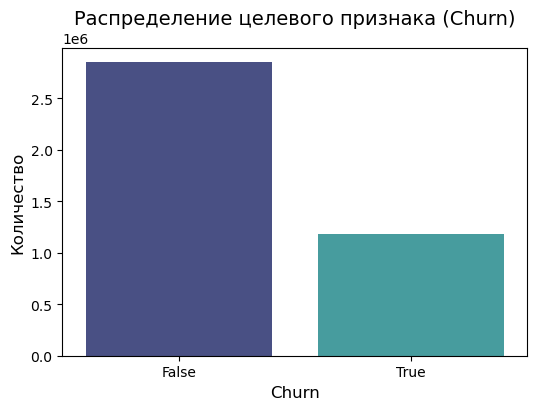

In [ ]:
# Распределение целевого признака
churn_counts = processed_train_df['churn'].value_counts()

# Визуализация
plt.figure(figsize=(6, 4))
sns.barplot(x=churn_counts.index, y=churn_counts.values, palette="mako")
plt.xlabel("Churn", fontsize=12)
plt.ylabel("Количество", fontsize=12)
plt.title("Распределение целевого признака (Churn)", fontsize=14)
plt.show()

Наблюдается дисбаланс классов

Визуализируем распределение всех признаков с разбивкой по целевому признаку.

Сформулируем гипотезы для проверки различий между группами и проверим их:

* **Нулевая гипотеза (H₀):**
Нет статистически значимых различий между группами клиентов с оттоком и без оттока по исследуемому признаку. Hазличия между средними значениями признака в двух группах случайны и не свидетельствуют о систематической разнице.

* **Альтернативная гипотеза (H₁):**
Существует статистически значимая разница между группами клиентов с оттоком и без оттока по исследуемому признаку. То есть наблюдаемые различия не случайны и указывают на влияние данного признака на вероятность оттока.

In [ ]:
def visualize_data(df, target=None, alpha=0.05):
    """
    Функция для визуализации данных с построением графиков распределения,
    гистограмм, boxplot (для непрерывных признаков) и pie-диаграмм (для категориальных признаков).
    Для каждого числового признака выводится результат t‑теста для проверки гипотезы,
    а для категориальных признаков – тест хи‑квадрат.

    Гипотеза для проверки различий между группами:
      Нулевая гипотеза (H₀):
        Нет статистически значимых различий между группами клиентов (с оттоком и без оттока)
        по исследуемому признаку.
      Альтернативная гипотеза (H₁):
        Существует статистически значимая разница между группами клиентов по исследуемому признаку.

    Параметры:
      df (DataFrame): Исходный DataFrame.
      dis_columns (list): Список дискретных столбцов.
      target (str): Имя целевого столбца.
      alpha (float): Уровень значимости для t‑теста и теста хи‑квадрат.

    Возвращает:
      significant_features (list): Список статистически значимых признаков (p < alpha).
    """
    # Список для накопления статистически значимых признаков
    significant_features = []

    # Проверка на пустой DataFrame
    if df.empty:
        print("Ошибка: DataFrame пуст.")
        return

    # Предобработка: удаляем пропуски
    df = df.dropna()

    # Определяем числовые признаки
    num_cols = df.select_dtypes(include=[np.number, bool]).columns.tolist()

    # Разделяем числовые признаки на непрерывные и дискретные
    num_discrete = [col for col in num_cols if df[col].nunique() < 100]
    num_continuous = [col for col in num_cols if col not in num_discrete]

    # Определяем категориальные признаки (тип object или category)
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    # Вспомогательная функция для построения графиков для числовых признаков
    def plot_numeric_features(features, plot_type='continuous'):
        """
        Строит графики для набора числовых признаков.
          Для непрерывных признаков (plot_type='continuous'):
            - Внутренняя сетка из 3 рядов:
                1. График распределения (KDE) (без подписи оси X) с объединённым заголовком.
                2. Boxplot (без заголовка и легенды) с согласованием осей.
                3. Текстовый блок с результатами t‑теста.
          Для дискретных признаков (plot_type='discrete'):
            - Внутренняя сетка из 2 рядов:
                1. Гистограмма с разделением по target.
                2. Текстовый блок с результатами t‑теста.
        """
        n_features = len(features)
        if n_features == 0:
            return
        # Определяем число строк внешней сетки (2 графика в ряд)
        n_rows = int(np.ceil(n_features / 2))
        fig = plt.figure(figsize=(16, n_rows * 6))
        outer_grid = gridspec.GridSpec(n_rows, 2, wspace=0.3, hspace=0.3)

        for i, col in enumerate(features):
            row = i // 2
            col_idx = i % 2

            if plot_type == 'continuous':
                # Внутренняя сетка из 3 рядов: распределение, boxplot, текст t-теста.
                inner_grid = gridspec.GridSpecFromSubplotSpec(
                    3, 1,
                    subplot_spec=outer_grid[row, col_idx],
                    height_ratios=[3, 1, 1.5],  # увеличено расстояние между boxplot и текстом
                    hspace=0.5
                )
                # 1. График распределения (KDE) без подписи оси X.
                ax0 = fig.add_subplot(inner_grid[0])
                sns.kdeplot(data=df, x=col, hue=target, common_norm=False, palette='mako', ax=ax0)
                # Объединённый заголовок для пары графиков: выводим название признака.
                ax0.set_title(f'Распределение и Boxplot: {col}', fontsize=12)
                ax0.set_xlabel('')  # убираем подпись оси X
                # Согласуем оси: получаем диапазон значений признака.
                x_min, x_max = df[col].min(), df[col].max()
                ax0.set_xlim(x_min, x_max)

                # 2. Boxplot без заголовка и легенды.
                ax1 = fig.add_subplot(inner_grid[1])
                sns.boxplot(data=df, x=col, hue=target, palette='mako', ax=ax1)
                ax1.set_xlim(x_min, x_max)
                ax1.set_title('')
                if ax1.get_legend():
                    ax1.get_legend().remove()

                # 3. Текстовый блок с результатом t‑теста.
                ax2 = fig.add_subplot(inner_grid[2])
                ax2.axis('off')
                if target and df[target].nunique() == 2:
                    groups = df[target].unique()
                    group1 = df[df[target] == groups[0]][col]
                    group2 = df[df[target] == groups[1]][col]
                    results = st.ttest_ind(group1, group2, equal_var=False)
                    t_text = f"t_stat = {results.statistic:.3f}, p_value = {results.pvalue:.5f}"
                    if results.pvalue < alpha:
                        result_text = "Отвергаем H₀: существует статистически значимые различия"
                        color = 'red'
                        if col not in significant_features:
                            significant_features.append(col)
                    else:
                        result_text = "Не отвергаем H₀: нет статистически значимых различий"
                        color = 'green'
                    ax2.text(0.05, 0.8, t_text, fontsize=10, color=color)
                    ax2.text(0.05, 0.5, result_text, fontsize=10, color=color)
                else:
                    ax2.text(0.05, 0.65, "Нет данных для t-теста", fontsize=10)

            else:
                # Для дискретных признаков: внутренняя сетка из 2 рядов (гистограмма и текст t‑теста).
                inner_grid = gridspec.GridSpecFromSubplotSpec(
                    2, 1,
                    subplot_spec=outer_grid[row, col_idx],
                    height_ratios=[3, 1.5],
                    hspace=0.5
                )
                # 1. Гистограмма с разделением по target.
                ax0 = fig.add_subplot(inner_grid[0])
                sns.histplot(data=df, x=col, hue=target, multiple="dodge", palette='mako', ax=ax0)
                ax0.set_title(f'Распределение {col}', fontsize=12)
                x_min, x_max = df[col].min(), df[col].max()
                ax0.set_xlim(x_min, x_max)

                # 2. Текстовый блок с результатом t‑теста.
                ax1 = fig.add_subplot(inner_grid[1])
                ax1.axis('off')
                if target and df[target].nunique() == 2:
                    groups = df[target].unique()
                    group1 = df[df[target] == groups[0]][col]
                    group2 = df[df[target] == groups[1]][col]
                    results = st.ttest_ind(group1, group2, equal_var=False)
                    t_text = f"t_stat = {results.statistic:.3f}, p_value = {results.pvalue:.5f}"
                    if results.pvalue < alpha:
                        result_text = "Отвергаем H₀: существует статистически значимые различия"
                        color = 'red'
                        if col not in significant_features:
                            significant_features.append(col)
                    else:
                        result_text = "Не отвергаем H₀: нет статистически значимых различий"
                        color = 'green'
                    ax1.text(0.05, 0.8, t_text, fontsize=10, color=color)
                    ax1.text(0.05, 0.5, result_text, fontsize=10, color=color)
                else:
                    ax1.text(0.05, 0.65, "Нет данных для t-теста", fontsize=10)

        plt.suptitle(f'Анализ числовых признаков ({plot_type})', fontsize=16, y=0.89)
        plt.tight_layout(rect=[0, 0, 1, 0.96], pad=2.0)
        plt.show()

    # Построение графиков для непрерывных признаков
    if num_continuous:
        plot_numeric_features(num_continuous, plot_type='continuous')

    # Построение графиков для дискретных признаков
    if num_discrete:
        plot_numeric_features(num_discrete, plot_type='discrete')

    # Построение графиков для категориальных признаков (Pie-диаграммы)
    if cat_cols:
        n_cat = len(cat_cols)
        n_cat_rows = int(np.ceil(n_cat / 2))
        fig = plt.figure(figsize=(14, n_cat_rows * 7))
        outer_grid = gridspec.GridSpec(n_cat_rows, 2, wspace=0.3, hspace=0.4)

        for i, col in enumerate(cat_cols):
            row = i // 2
            col_idx = i % 2
            # Внутренняя сетка для категориального признака: 2 ряда (pie и текст теста хи‑квадрат)
            inner_grid = gridspec.GridSpecFromSubplotSpec(
                2, 1,
                subplot_spec=outer_grid[row, col_idx],
                height_ratios=[4, 1],
                hspace=0.5
            )
            # 1. Pie-диаграмма
            ax0 = fig.add_subplot(inner_grid[0])
            top_values = df[col].value_counts().nlargest(5)
            df_temp = df.copy()
            df_temp[col] = df_temp[col].apply(lambda x: x if x in top_values.index else 'Прочие')
            df_temp[col].value_counts().plot(kind='pie', autopct='%1.1f%%', ylabel='',
                                            colors=sns.color_palette('mako'), ax=ax0)
            ax0.set_title(f'Распределение: {col}', fontsize=12)
            ax0.set_ylabel('')

            # 2. Текстовый блок для теста хи‑квадрат
            ax1 = fig.add_subplot(inner_grid[1])
            ax1.axis('off')
            if target and df[target].nunique() == 2:
                contingency_table = pd.crosstab(df_temp[col], df_temp[target])
                chi2, p, _, _ = st.chi2_contingency(contingency_table)
                t_text = f"chi2 = {chi2:.3f}, p_value = {p:.5f}"
                if p < alpha:
                    result_text = "Отвергаем H₀: существует статистически значимые различия"
                    color = 'red'
                    if col not in significant_features:
                        significant_features.append(col)
                else:
                    result_text = "Не отвергаем H₀: нет статистически значимых различий"
                    color = 'green'
                ax1.text(0.05, 0.8, t_text, fontsize=10, color=color)
                ax1.text(0.05, 0.5, result_text, fontsize=10, color=color)
            else:
                ax1.text(0.05, 0.65, "Нет данных для теста хи‑квадрат", fontsize=10)
        plt.suptitle('Анализ категориальных признаков (Pie-диаграммы)', fontsize=16, y=0.98)
        plt.tight_layout(rect=[0, 0, 1, 0.96], pad=2.0)
        plt.show()

    # Возвращаем список статистически значимых признаков
    return significant_features

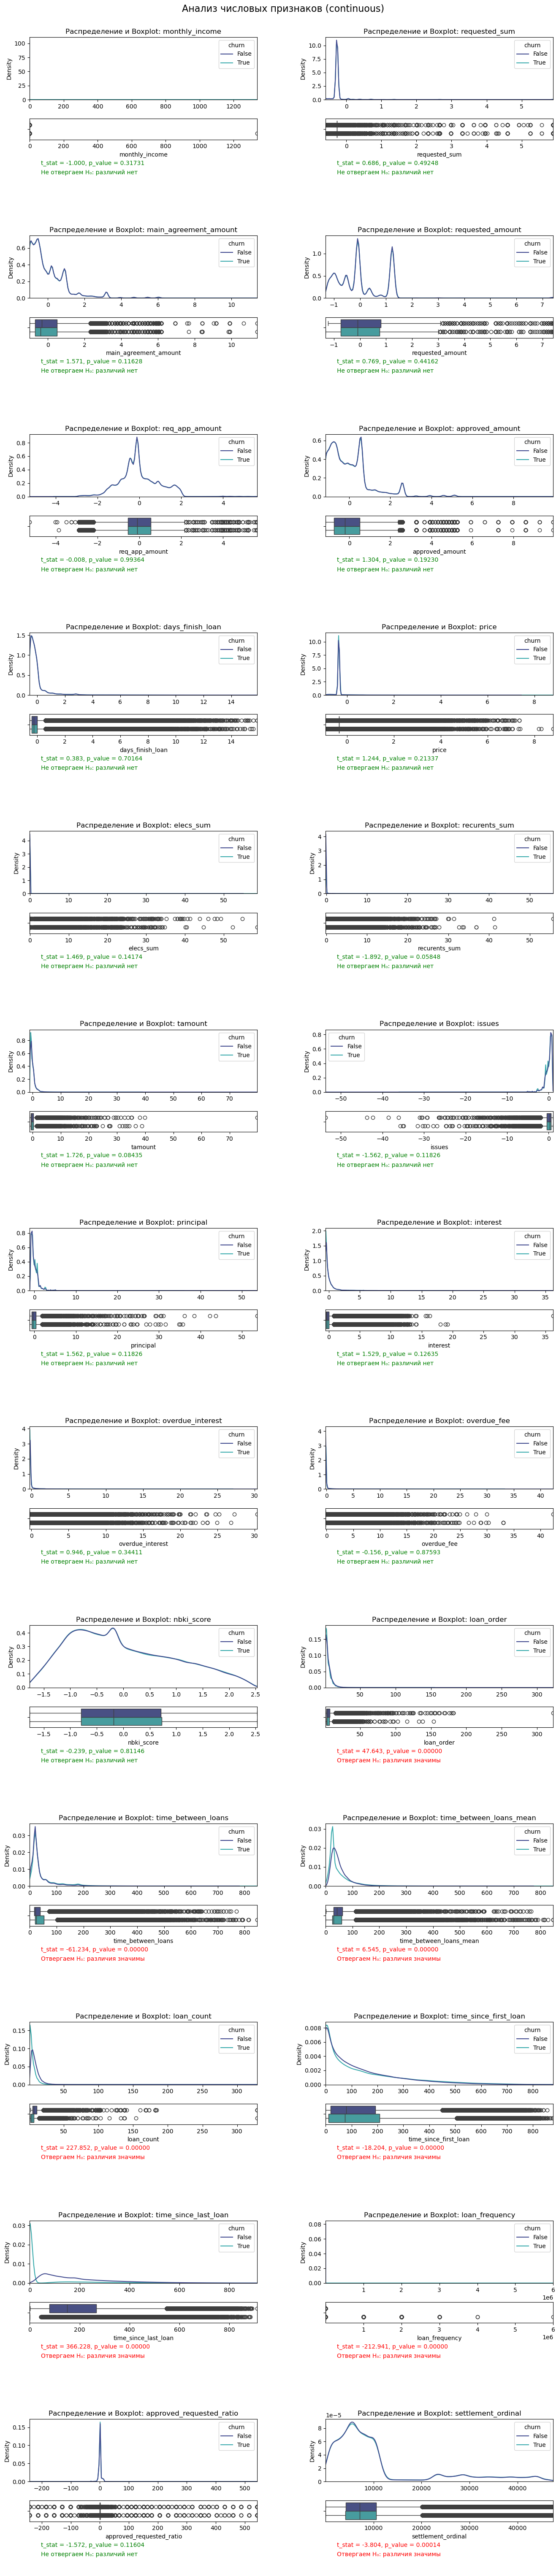

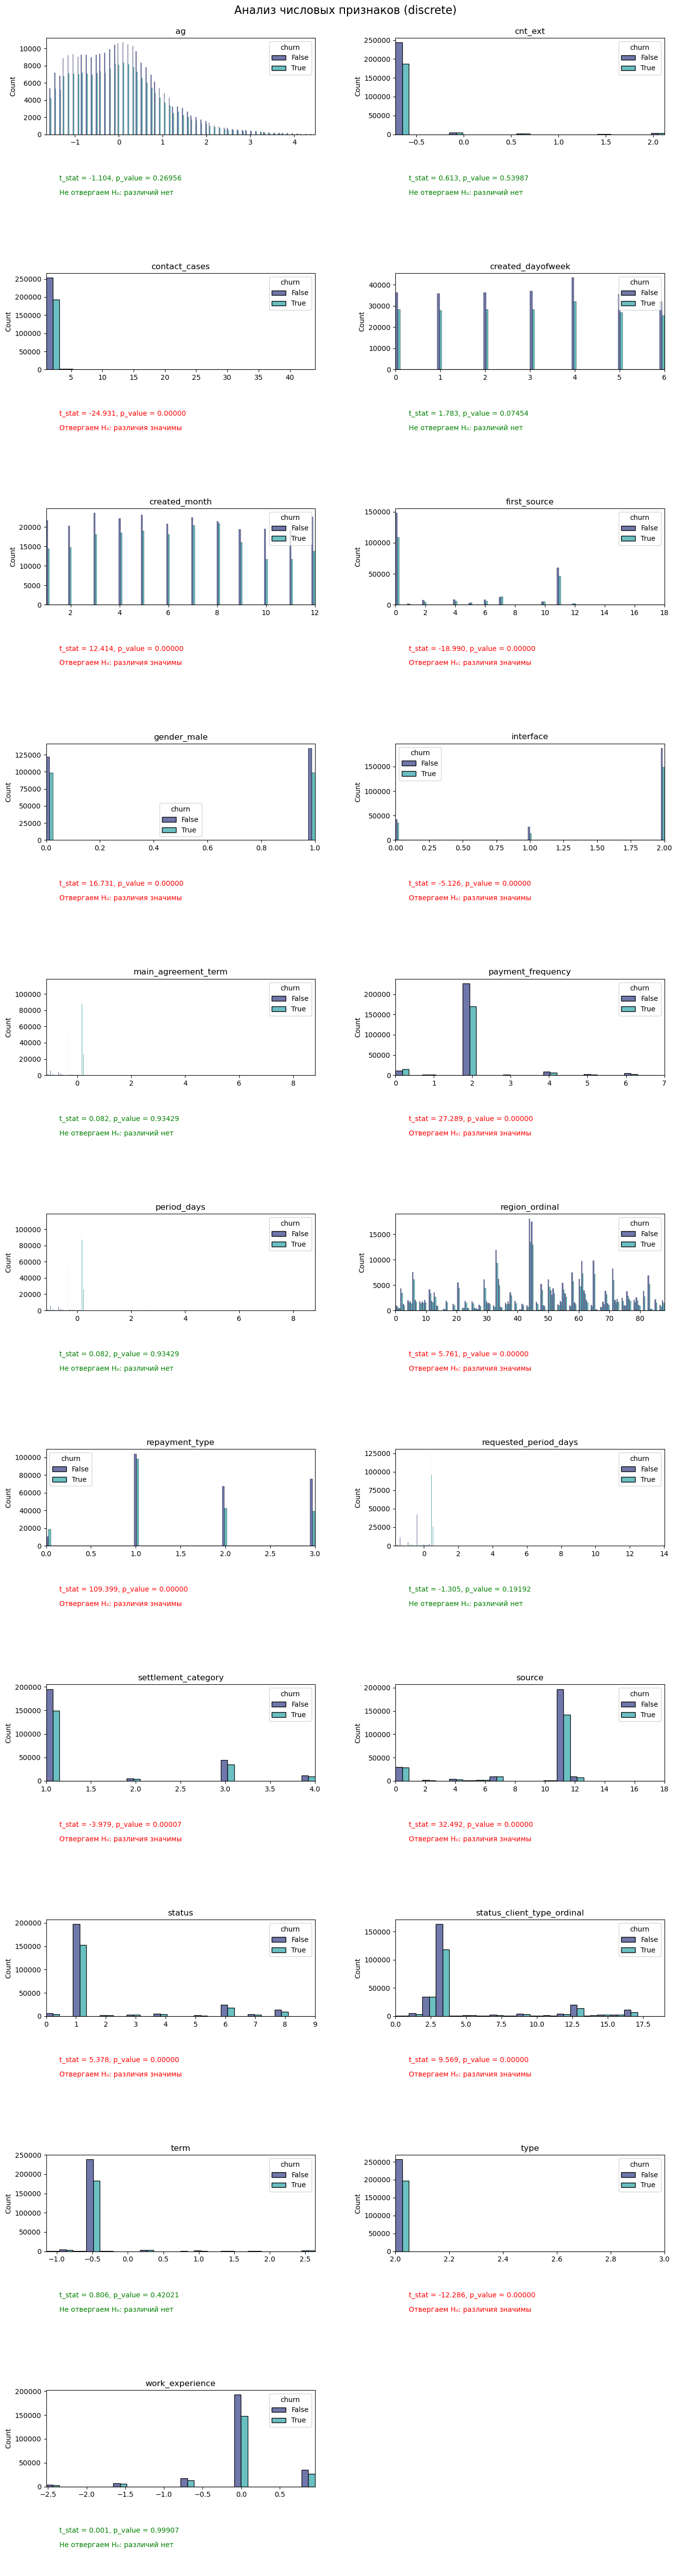

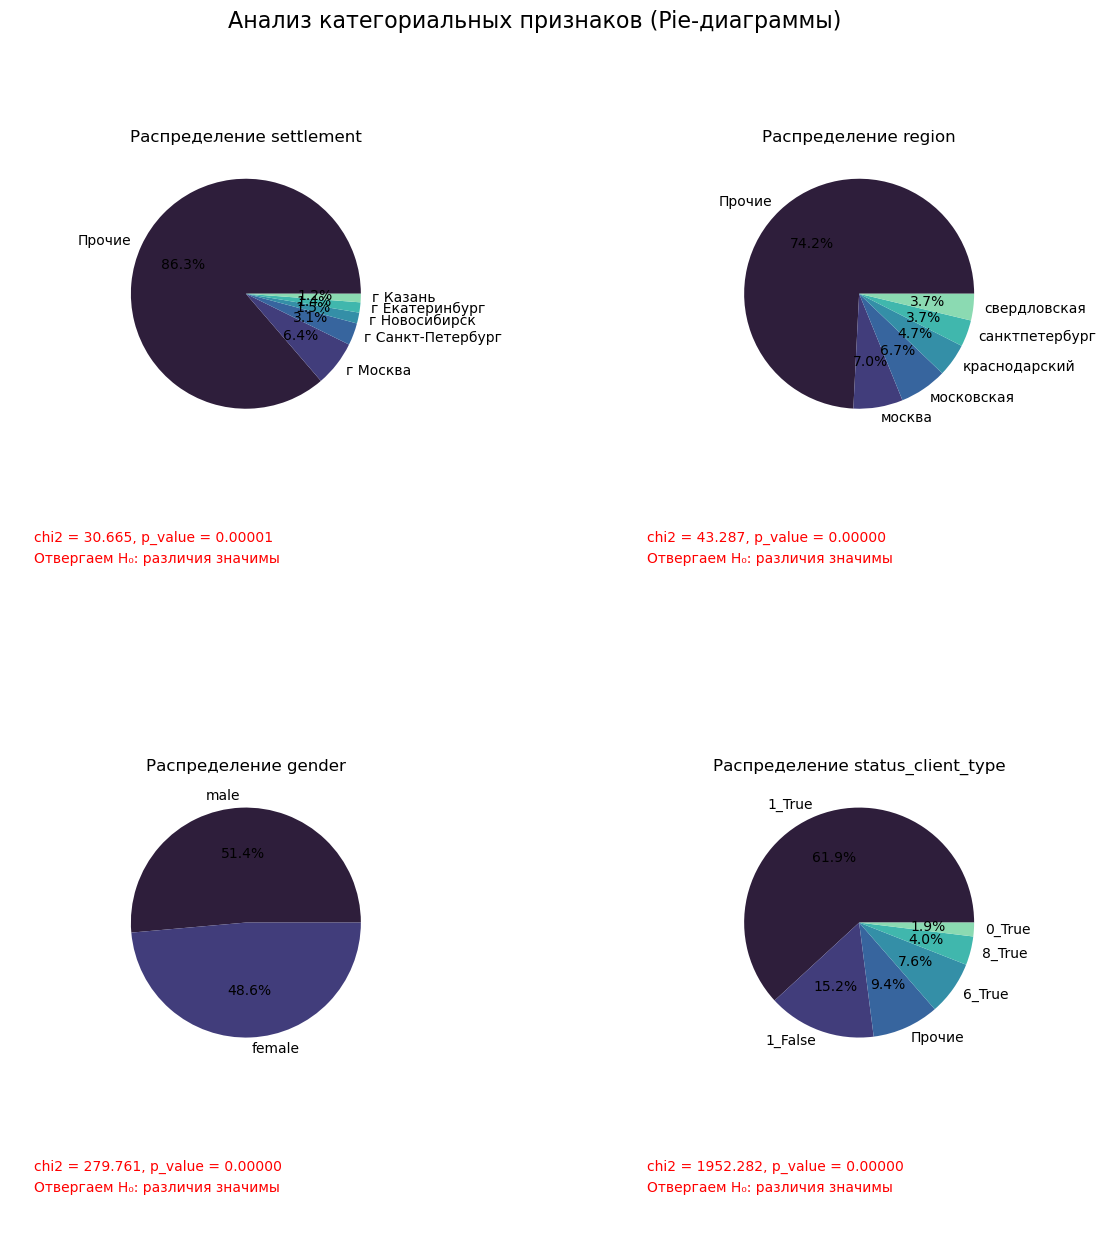

['loan_order',
 'time_between_loans',
 'time_between_loans_mean',
 'loan_count',
 'time_since_first_loan',
 'time_since_last_loan',
 'loan_frequency',
 'settlement_ordinal',
 'contact_cases',
 'created_month',
 'first_source',
 'gender_male',
 'interface',
 'payment_frequency',
 'region_ordinal',
 'repayment_type',
 'settlement_category',
 'source',
 'status',
 'status_client_type_ordinal',
 'type',
 'settlement',
 'region',
 'gender',
 'status_client_type']

In [ ]:
significant_features = visualize_data(processed_train_df.drop(columns=["loan_id", "client_id"]),
               target='churn')

print('Признаки, для которых выявлены статистически значимые различия между клиентами, склонными к оттоку, и теми, кто не склонен к нему:')
print(significant_features)

### Корреляция

Посмотрим на корреляцию признаков в тренировочном датасете

In [ ]:
interval_features = [
    'monthly_income', 'requested_sum', 'main_agreement_amount',
    'main_agreement_term', 'requested_period_days', 'requested_amount',
    'req_app_amount', 'approved_amount', 'period_days', 'days_finish_loan',
    'ag', 'term', 'price', 'elecs_sum', 'recurents_sum', 'tamount', 'issues',
    'principal', 'interest', 'overdue_interest', 'overdue_fee', 'nbki_score',
    'source', 'first_source', 'settlement', 'region', 'loan_order',
    'contact_cases', 'time_between_loans', 'time_between_loans_mean',
    'loan_count', 'time_since_first_loan', 'time_since_last_loan',
    'loan_frequency'
]

In [ ]:
# Выбираем все числовые столбцы (исключая булевы, так как у них всего 2 уникальных значения)
numeric_cols = processed_train_df.select_dtypes(include=[np.number]).columns

# Фильтруем столбцы: оставляем те, у которых число уникальных значений больше порога
threshold = 100
interval_features = [col for col in numeric_cols if processed_train_df[col].nunique() > threshold]

print("Найденные интервальные признаки:")
print(interval_features)

Найденные интервальные признаки:
['monthly_income', 'requested_sum', 'main_agreement_amount', 'requested_amount', 'req_app_amount', 'approved_amount', 'days_finish_loan', 'price', 'elecs_sum', 'recurents_sum', 'tamount', 'issues', 'principal', 'interest', 'overdue_interest', 'overdue_fee', 'nbki_score', 'loan_id', 'client_id', 'loan_order', 'time_between_loans', 'time_between_loans_mean', 'loan_count', 'time_since_first_loan', 'time_since_last_loan', 'loan_frequency', 'approved_requested_ratio', 'settlement_ordinal']


In [ ]:
# Подготовка данных: выбираем только числовые и булевы признаки, исключая идентификаторы
sample_data = processed_train_df.drop(['loan_id', 'client_id'], axis=1).select_dtypes(include=[np.number, bool])

In [ ]:
# Вычисление матрицы корреляции φK
phik_overview = sample_data.phik_matrix(interval_cols=interval_features)

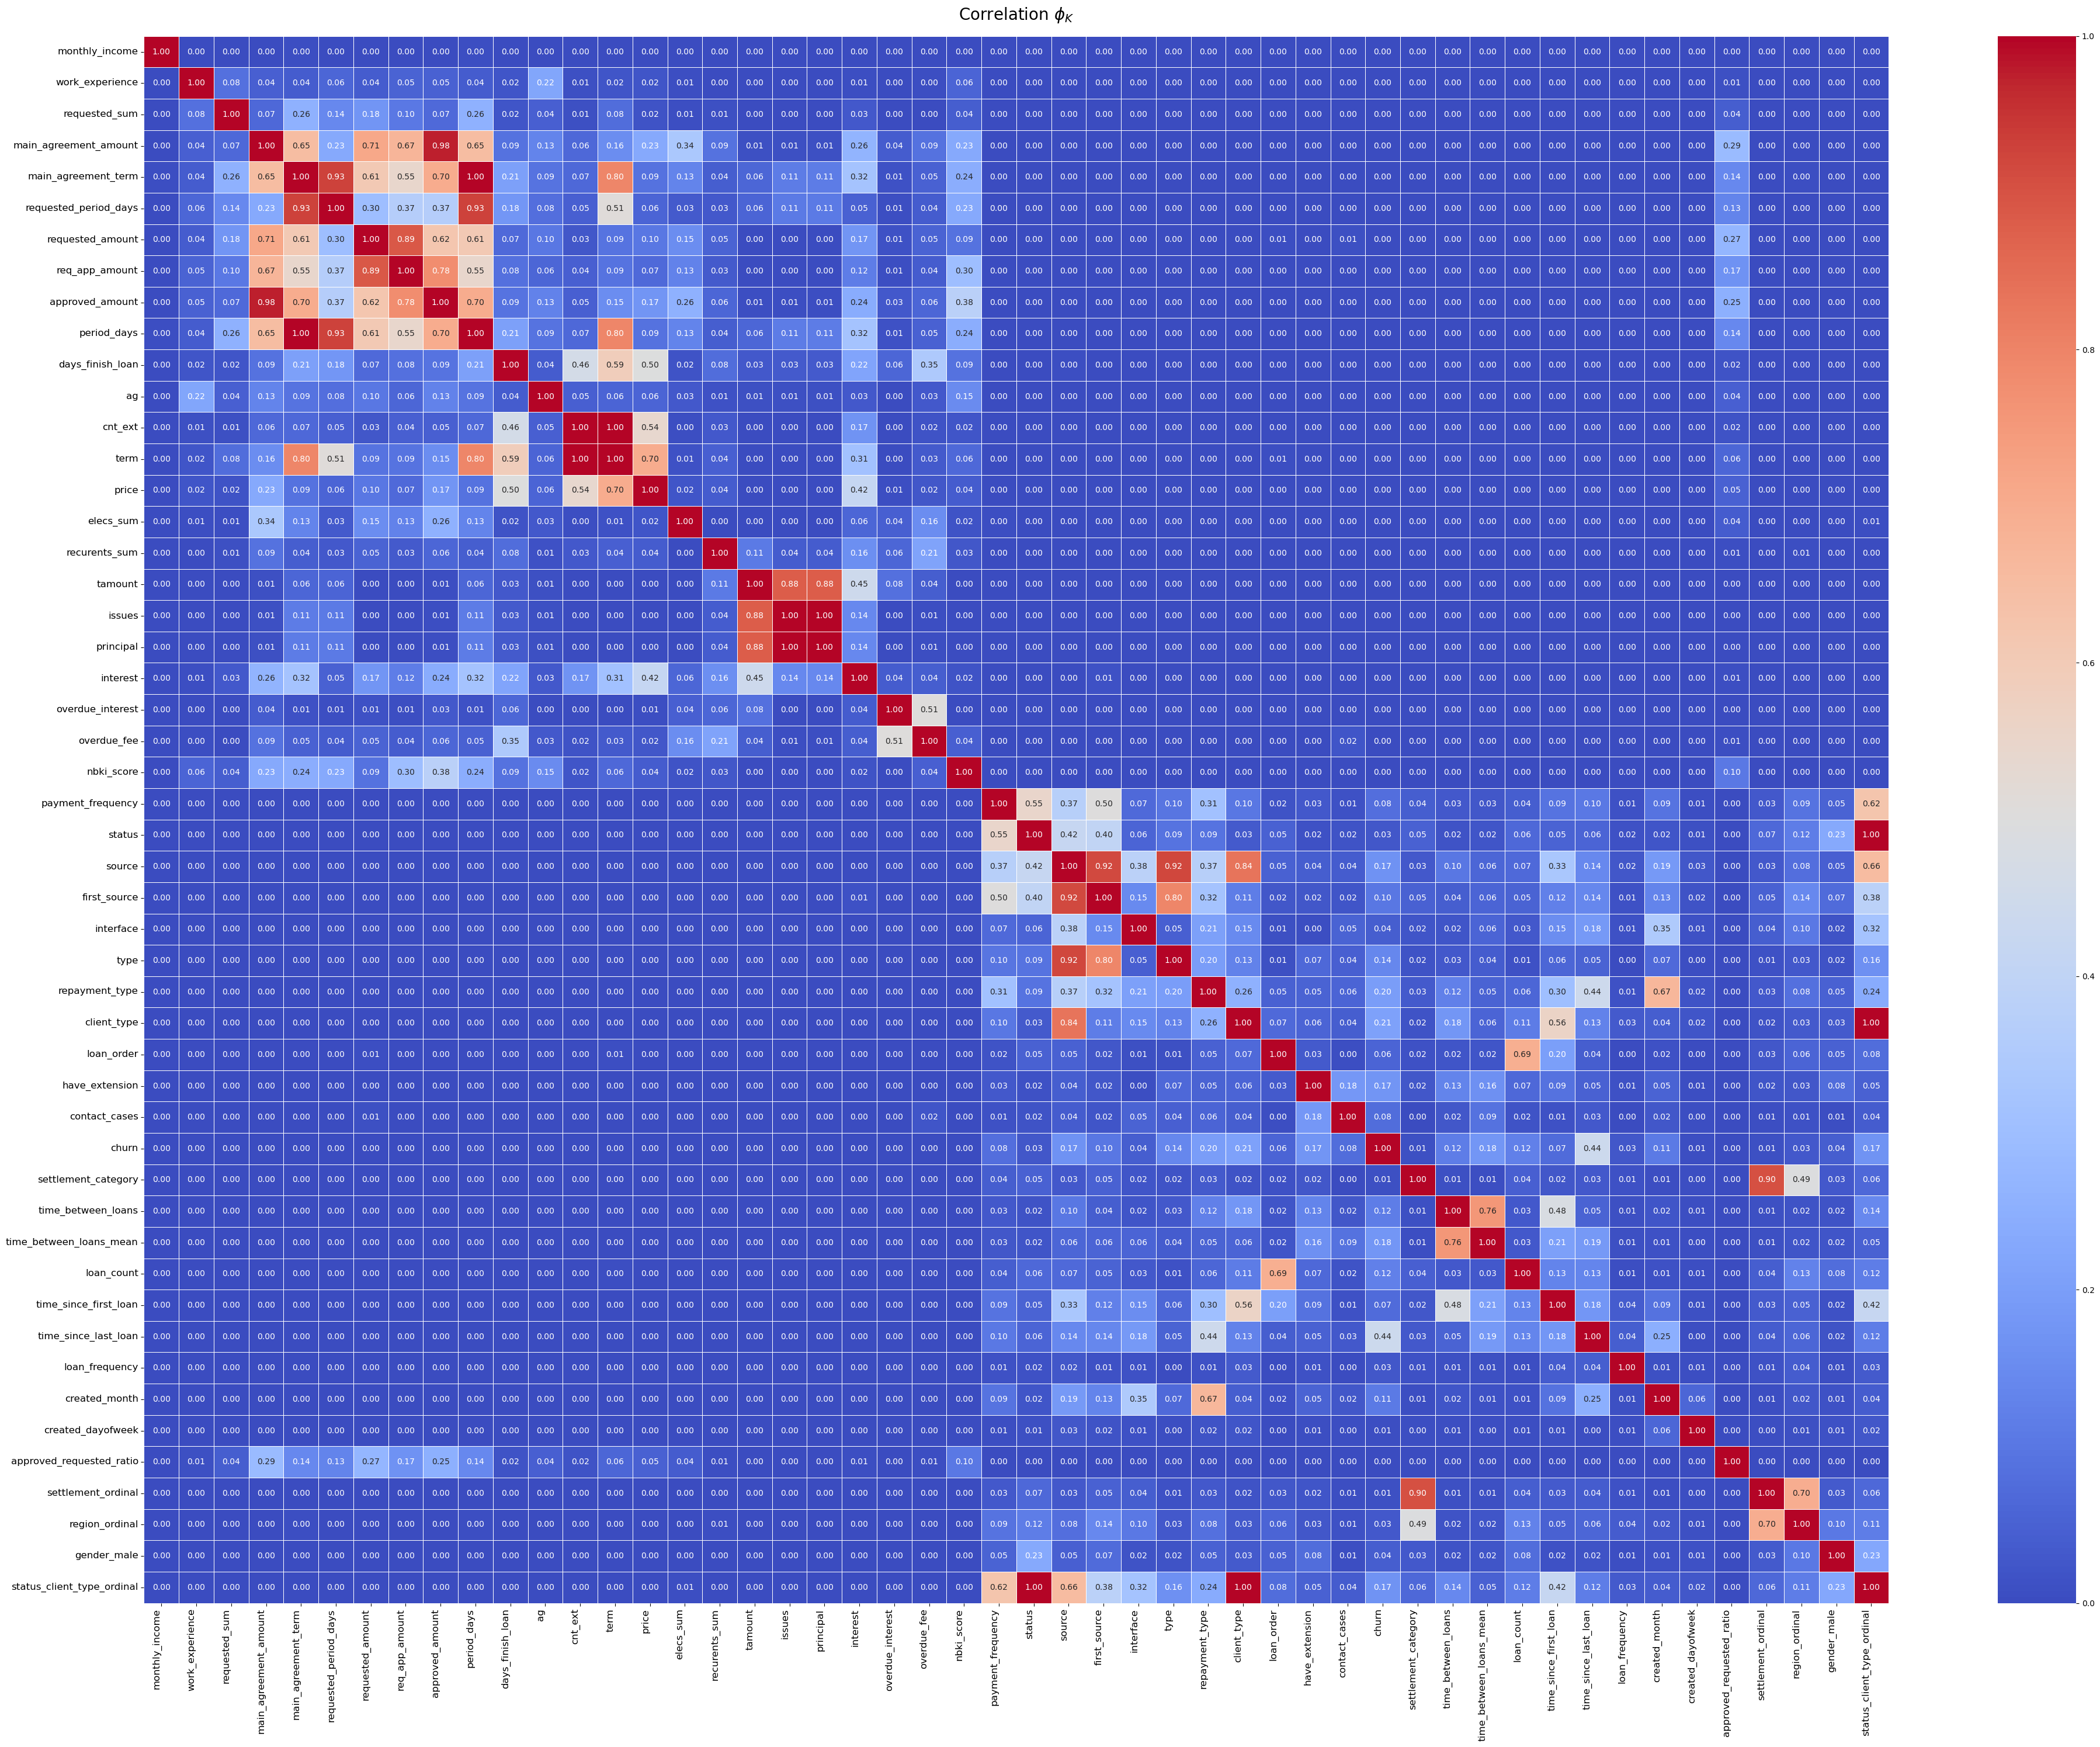

In [ ]:
# Построение тепловой карты
fig, ax = plt.subplots(figsize=(40, 30))
sns.heatmap(
    phik_overview.values,  # Данные для heatmap
    annot=True,            # Добавить аннотации (значения в ячейках)
    fmt=".2f",             # Формат чисел в аннотациях
    cmap='coolwarm',       # Цветовая палитра
    vmin=0,                # Минимальное значение для шкалы
    vmax=1,                # Максимальное значение для шкалы
    linewidths=0.5,        # Ширина линий между ячейками
    ax=ax                  # Ось для отрисовки
)

# Настройка осей и заголовка
ax.set_xticklabels(phik_overview.columns,
                   rotation=90, ha='right',
                   fontsize=12)
ax.set_yticklabels(phik_overview.index,
                   rotation=0, fontsize=12)
ax.set_title('Correlation $\phi_K$',
             fontsize=20,
             pad=20)

# Отображение графика
plt.tight_layout()
plt.show()

In [ ]:
# Извлекаем корреляции с целевым признаком 'churn'
target_corr = phik_overview['churn'].copy()
target_corr.drop('churn', errors='ignore', inplace=True)

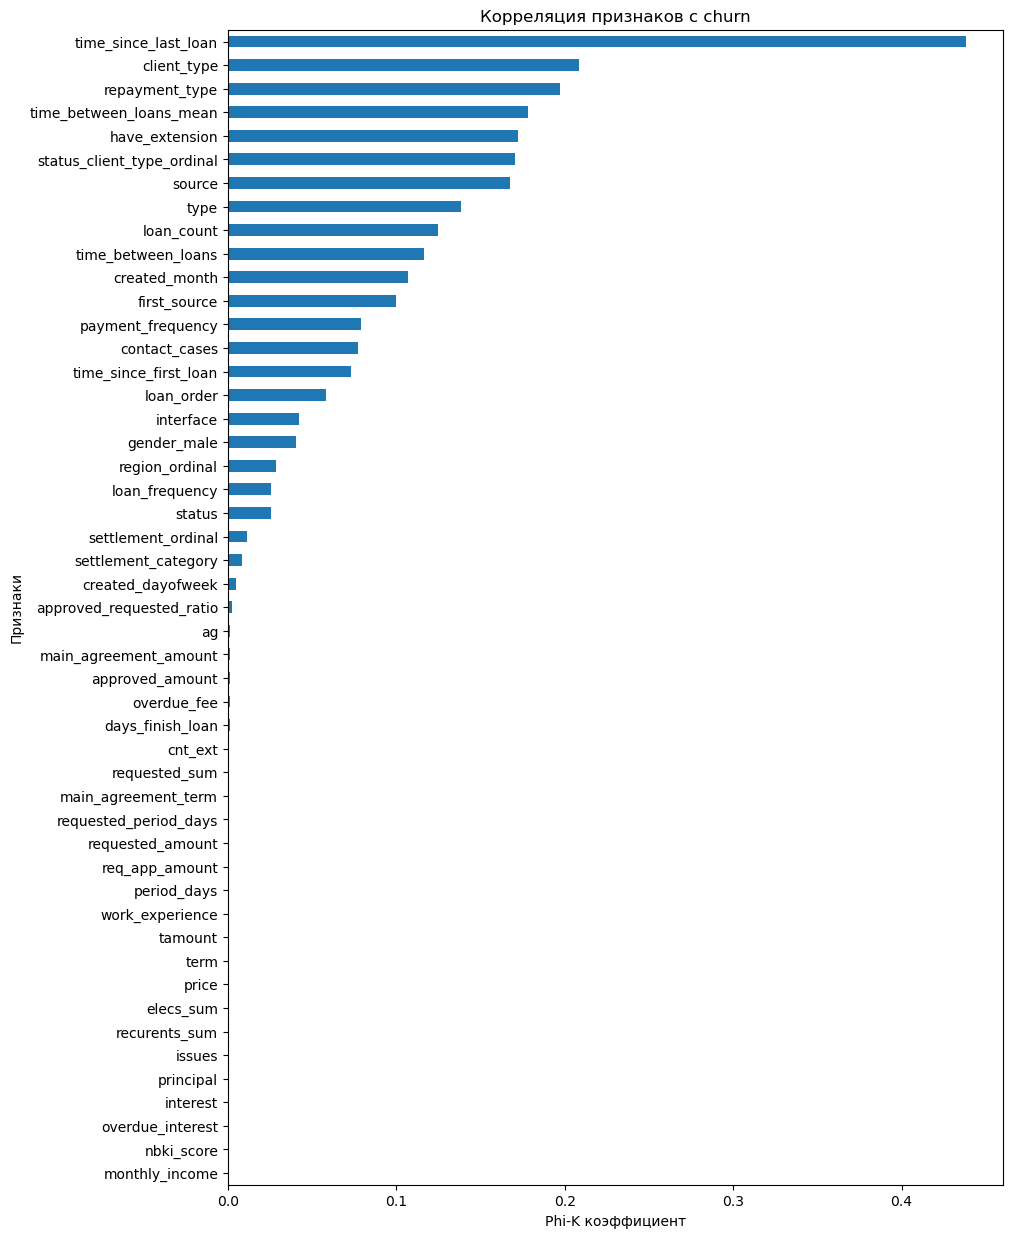

In [ ]:
# Построение горизонтальной диаграммы корреляций с churn
target_corr.sort_values().plot.barh(figsize=(10, 15))
plt.title("Корреляция признаков с churn")
plt.xlabel("Phi-K коэффициент")
plt.ylabel("Признаки")
plt.show()

In [ ]:
# Признаки с "нулевой" корреляцией
zero_threshold = 0.002
zero_corr_features = target_corr[abs(target_corr) < zero_threshold].index.tolist()

# Вывод результатов
print(f"Признаки с корреляцией близкой к нулю (<{zero_threshold}) с churn:")
print(zero_corr_features)

Признаки с корреляцией близкой к нулю (<0.002) с churn:
['monthly_income', 'work_experience', 'requested_sum', 'main_agreement_amount', 'main_agreement_term', 'requested_period_days', 'requested_amount', 'req_app_amount', 'approved_amount', 'period_days', 'days_finish_loan', 'ag', 'cnt_ext', 'term', 'price', 'elecs_sum', 'recurents_sum', 'tamount', 'issues', 'principal', 'interest', 'overdue_interest', 'overdue_fee', 'nbki_score']


In [ ]:
# Анализ мультиколлинеарности: находим пары признаков с φK > threshold
threshold = 0.95
corr_matrix = phik_overview.values

# Находим индексы верхнего треугольника матрицы (исключая диагональ)
upper_triangle = np.triu(corr_matrix, k=1)
high_corr_indices = np.where(upper_triangle > threshold)

# Собираем пары признаков и их значения корреляции
multicollinear_pairs = []
for i, j in zip(*high_corr_indices):
    pair = (phik_overview.columns[i], phik_overview.columns[j], corr_matrix[i, j])
    multicollinear_pairs.append(pair)

print("Пары признаков с мультиколлинеарностью:")
for pair in multicollinear_pairs:
    print(f"{pair[0]} и {pair[1]}: φk = {pair[2]:.2f}")

Пары признаков с мультиколлинеарностью:
main_agreement_amount и approved_amount: φk = 0.98
main_agreement_term и period_days: φk = 1.00
cnt_ext и term: φk = 1.00
issues и principal: φk = 1.00
status и status_client_type_ordinal: φk = 1.00
client_type и status_client_type_ordinal: φk = 1.00


In [ ]:
# Освобождаем память
sample_data = None
gc.collect()

423513

Удалим признаки с нулевой корреляцией с целевым признаком и признаки, вызывающие мультиколлинеарность, а так же уникальные идентификаторы и признаки содержащие даты.

In [ ]:
# Формируем список столбцов для удаления: объединяем признаки с нулевой корреляцией и дополнительные столбцы
columns_to_drop = zero_corr_features + ['client_id', 'created_at', 'start_dt', 'status', 'client_type', 'approved_amount', 'period_days']
print("Список столбцов для удаления:")
print(columns_to_drop)

Список столбцов для удаления:
['monthly_income', 'work_experience', 'requested_sum', 'main_agreement_amount', 'main_agreement_term', 'requested_period_days', 'requested_amount', 'req_app_amount', 'approved_amount', 'period_days', 'days_finish_loan', 'ag', 'cnt_ext', 'term', 'price', 'elecs_sum', 'recurents_sum', 'tamount', 'issues', 'principal', 'interest', 'overdue_interest', 'overdue_fee', 'nbki_score', 'client_id', 'created_at', 'start_dt', 'status', 'client_type', 'approved_amount', 'period_days']


In [ ]:
# Удаляем указанные столбцы из тренировочного набора и сохраняем результат
print('Удаляем указанные столбцы из тренировочного набора и сохраняем результат')
train_df = processed_train_df.drop(columns=columns_to_drop)
print("Оставшиеся столбцы в train:")
print(train_df.columns)

Удаляем указанные столбцы из тренировочного набора и сохраняем результат
Оставшиеся столбцы в train:
Index(['payment_frequency', 'loan_id', 'source', 'first_source', 'interface',
       'type', 'repayment_type', 'settlement', 'region', 'gender',
       'loan_order', 'have_extension', 'contact_cases', 'churn',
       'settlement_category', 'time_between_loans', 'time_between_loans_mean',
       'loan_count', 'time_since_first_loan', 'time_since_last_loan',
       'loan_frequency', 'created_month', 'created_dayofweek',
       'approved_requested_ratio', 'status_client_type', 'settlement_ordinal',
       'region_ordinal', 'gender_male', 'status_client_type_ordinal'],
      dtype='object')


In [ ]:
# Сохранение нового DataFrame
train_df.to_csv(PATH_SAVE / 'train_df.csv', index=False)

In [ ]:
# Аналогично для тестового набора
print("Удаляем указанные столбцы из тестового набора и сохраняем результат")
X_test = processed_test_df.drop(columns=columns_to_drop)
print("Оставшиеся столбцы в test:")
print(X_test.columns)

Удаляем указанные столбцы из тестового набора и сохраняем результат
Оставшиеся столбцы в test:
Index(['payment_frequency', 'loan_id', 'source', 'first_source', 'interface',
       'type', 'repayment_type', 'settlement', 'region', 'gender',
       'loan_order', 'have_extension', 'contact_cases', 'settlement_category',
       'time_between_loans', 'time_between_loans_mean', 'loan_count',
       'time_since_first_loan', 'time_since_last_loan', 'loan_frequency',
       'created_month', 'created_dayofweek', 'approved_requested_ratio',
       'status_client_type', 'settlement_ordinal', 'region_ordinal',
       'gender_male', 'status_client_type_ordinal'],
      dtype='object')


In [ ]:
# Сохранение нового DataFrame
X_test.to_csv(PATH_SAVE / 'X_test.csv', index=False)

In [ ]:
# Очистка памяти
processed_train_df = None
processed_test_df = None
gc.collect()

0

## Обучение моделей

### Разделение выборок

In [ ]:
# Разделение на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(
    train_df.drop(['churn'], axis=1).copy(),
    train_df['churn'],
    test_size=0.2,
    random_state=RANDOM_STATE
)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3228965 entries, 455678 to 2219110
Data columns (total 28 columns):
 #   Column                      Dtype   
---  ------                      -----   
 0   payment_frequency           int8    
 1   loan_id                     int32   
 2   source                      int8    
 3   first_source                int8    
 4   interface                   int8    
 5   type                        int8    
 6   repayment_type              int8    
 7   settlement                  category
 8   region                      object  
 9   gender                      category
 10  loan_order                  int16   
 11  have_extension              bool    
 12  contact_cases               float64 
 13  settlement_category         int32   
 14  time_between_loans          float64 
 15  time_between_loans_mean     float64 
 16  loan_count                  int64   
 17  time_since_first_loan       int64   
 18  time_since_last_loan        int64   
 19  

In [ ]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 3228965 entries, 455678 to 2219110
Series name: churn
Non-Null Count    Dtype
--------------    -----
3228965 non-null  bool 
dtypes: bool(1)
memory usage: 27.7 MB


In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348743 entries, 0 to 1348742
Data columns (total 28 columns):
 #   Column                      Non-Null Count    Dtype   
---  ------                      --------------    -----   
 0   payment_frequency           1348743 non-null  int8    
 1   loan_id                     1348743 non-null  int32   
 2   source                      1348743 non-null  int8    
 3   first_source                1348743 non-null  int8    
 4   interface                   1348743 non-null  int8    
 5   type                        1348743 non-null  int8    
 6   repayment_type              1348743 non-null  int8    
 7   settlement                  1348743 non-null  category
 8   region                      1348743 non-null  object  
 9   gender                      1348743 non-null  category
 10  loan_order                  1348743 non-null  int16   
 11  have_extension              1348743 non-null  bool    
 12  contact_cases               1348743 non-nu

Зададим список признаков без закодированных категориальных признаков

In [ ]:
non_encoded_cat_features = X_train.columns.difference(['settlement_ordinal',
                                              'region_ordinal',
                                              'gender_male',
                                              'status_client_type_ordinal',
                                              'loan_id'
                                               ])
non_encoded_cat_features

Index(['approved_requested_ratio', 'contact_cases', 'created_dayofweek',
       'created_month', 'first_source', 'gender', 'have_extension',
       'interface', 'loan_count', 'loan_frequency', 'loan_order',
       'payment_frequency', 'region', 'repayment_type', 'settlement',
       'settlement_category', 'source', 'status_client_type',
       'time_between_loans', 'time_between_loans_mean',
       'time_since_first_loan', 'time_since_last_loan', 'type'],
      dtype='object')

Зададим список признаков с закодированными категориальными признаками

In [ ]:
encoded_cat_features = X_train.columns.difference(['settlement',
                                                'region',
                                                'gender',
                                                'status_client_type',
                                                'loan_id'
                                               ])
encoded_cat_features

Index(['approved_requested_ratio', 'contact_cases', 'created_dayofweek',
       'created_month', 'first_source', 'gender_male', 'have_extension',
       'interface', 'loan_count', 'loan_frequency', 'loan_order',
       'payment_frequency', 'region_ordinal', 'repayment_type',
       'settlement_category', 'settlement_ordinal', 'source',
       'status_client_type_ordinal', 'time_between_loans',
       'time_between_loans_mean', 'time_since_first_loan',
       'time_since_last_loan', 'type'],
      dtype='object')

Определим категориальные признаки

In [ ]:
cat_features = [
    'payment_frequency', 'source', 'first_source', 'interface',
    'type', 'repayment_type', 'settlement', 'region',
    'gender', 'loan_order', 'settlement_category', 'status_client_type'
]
cat_features

['payment_frequency',
 'source',
 'first_source',
 'interface',
 'type',
 'repayment_type',
 'settlement',
 'region',
 'gender',
 'loan_order',
 'settlement_category',
 'status_client_type']

### Рассчитаем веса классов

In [ ]:
# Вычисление весов классов на обучающей выборке
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, class_weights))

# Для XGBoost вместо параметра class_weight используется scale_pos_weight.
# scale_pos_weight рассчитывается как соотношение количества отрицательных примеров к положительным.
scale_pos_weight = class_weights_dict[False] / class_weights_dict[True]

### CatBoost

#### Найдём оптимальные гиперпараметры для модели

In [ ]:
def objective_catboost(trial):
    # Задаём гиперпараметры с возможностью выбора через trial
    params = {
        "iterations": trial.suggest_int("iterations", 1000, 3000, step=500),
        "depth": trial.suggest_int("depth", 4, 10, step=2),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 1),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_seed": RANDOM_STATE,
        "task_type": DEVICE,
        "eval_metric": "F1",
        "cat_features": cat_features
    }

    # Инициализируем модель с гиперпараметрами
    model = CatBoostClassifier(**params)
    model.fit(
        X_train[non_encoded_cat_features], y_train,
        eval_set=(X_val[non_encoded_cat_features], y_val),
        early_stopping_rounds=50,
        use_best_model=True,
        verbose=0,
        class_weights=[class_weights_dict[False],
                       class_weights_dict[True]]
)
    )

    # Предсказания на валидационном наборе
    preds = model.predict(X_val[non_encoded_cat_features])
    f1 = f1_score(y_val, preds)

    # Регистрация промежуточных результатов для возможности обрезки
    trial.report(f1, step=trial.number)

    # Если результат ниже порога, мы прекращаем эксперимент (prune)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return f1

In [ ]:
# Настройка прунера
pruner = optuna.pruners.MedianPruner()

# Указываем хранилище – например, SQLite база данных
storage_catboost = "sqlite:///study_catbbost.db"

# Создание или загрузка исследования с именем "study_catbbost"
study_catboost = optuna.create_study(
    study_name="study_catbbost",
    direction="maximize",
    pruner=pruner,
    storage=storage_catboost,
    load_if_exists=True  # Если исследование уже существует, загрузить его
)

# Оптимизация целевой функции для CatBoost
study_catboost.optimize(objective_catboost, n_trials=40, timeout=21600)  #40 trials или 6 часов

best_params_cat = study_catboost.best_params

[I 2025-02-20 09:22:53,460] Using an existing study with name 'study_catbbost' instead of creating a new one.
[I 2025-02-20 09:26:07,310] Trial 33 finished with value: 0.9117103987729371 and parameters: {'iterations': 2000, 'depth': 6, 'learning_rate': 0.6215722798667965, 'l2_leaf_reg': 0.18386489144657048, 'border_count': 223}. Best is trial 33 with value: 0.9117103987729371.
[I 2025-02-20 09:29:27,123] Trial 34 finished with value: 0.9116325511732402 and parameters: {'iterations': 1500, 'depth': 4, 'learning_rate': 0.9631163619777726, 'l2_leaf_reg': 0.23648404387622704, 'border_count': 219}. Best is trial 33 with value: 0.9117103987729371.
[I 2025-02-20 09:31:46,888] Trial 35 finished with value: 0.9110533113134104 and parameters: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.9129940001506351, 'l2_leaf_reg': 0.1867558479686986, 'border_count': 218}. Best is trial 33 with value: 0.9117103987729371.
[I 2025-02-20 09:35:03,627] Trial 36 finished with value: 0.9114947724456498 and 

In [ ]:
best_params_cat = study_catboost.best_params
# Вывод лучшего результата и параметров
print("Лучший F1-score на валидационной выборке:", study_catboost.best_value)
print("Лучшие гиперпараметры:")
for key, value in best_params_cat.items():
    print(f"  {key}: {value}")

Лучший F1-score на валидационной выборке: 0.9122926142687229
Лучшие гиперпараметры:
  iterations: 2500
  depth: 8
  learning_rate: 0.13821493790358336
  l2_leaf_reg: 3.926232424209116
  border_count: 152


#### Обучение модели с лучшими гиперпараметрами

In [ ]:
# Обучение модели с лучшими параметрами
catboost_model = CatBoostClassifier(
    **best_params_cat,
    task_type=DEVICE,
    cat_features=cat_features,
    eval_metric='F1',
    verbose=100,
    class_weights=[class_weights_dict[False],
                   class_weights_dict[True]]
)

In [ ]:
# Обучение модели
try:
    catboost_model.fit(
        X_train[non_encoded_cat_features], y_train,
        eval_set=(X_val[non_encoded_cat_features], y_val),
        early_stopping_rounds=50,
        use_best_model=True
    )
except Exception as e:
    print(f"Ошибка при обучении: {e}")

0:	learn: 0.9093120	test: 0.9086643	best: 0.9086643 (0)	total: 984ms	remaining: 40m 58s
100:	learn: 0.9209786	test: 0.9204209	best: 0.9204209 (100)	total: 1m 14s	remaining: 29m 36s
200:	learn: 0.9231432	test: 0.9221861	best: 0.9222010 (197)	total: 2m 30s	remaining: 28m 39s
300:	learn: 0.9241955	test: 0.9229383	best: 0.9229383 (300)	total: 3m 44s	remaining: 27m 17s
400:	learn: 0.9248806	test: 0.9231767	best: 0.9232019 (388)	total: 5m	remaining: 26m 14s
500:	learn: 0.9255169	test: 0.9233900	best: 0.9233900 (500)	total: 6m 16s	remaining: 25m
600:	learn: 0.9262163	test: 0.9234912	best: 0.9235542 (596)	total: 7m 31s	remaining: 23m 46s
bestTest = 0.9235541687
bestIteration = 596
Shrink model to first 597 iterations.


In [ ]:
# Получение лучшего значения метрики
f1_val_catboost = catboost_model.get_best_score()['validation']['F1']
print(f"F1-score на валидационной выборке: : {f1_val_catboost:.5f}")

F1-score на валидационной выборке: : 0.92355


#### Предсказание на тестовом датасете

In [ ]:
# Предсказание вероятностей на тестовом датасете
start_time = time.time()  # Запускаем таймер
catboost_test_pred = catboost_model.predict(X_test[non_encoded_cat_features])
prediction_time_catboost = time.time() - start_time  # Вычисляем затраченное время

print(f"Время предсказания модели: {prediction_time_catboost:.1f} секунд")

Время предсказания модели: 11.3 секунд


#### Сформируем и сохраним файл `submission` для CatBoost

In [ ]:
submission_catboost = pd.DataFrame({
    "loan_id": X_test["loan_id"],  # ID кредита
    "churn": catboost_test_pred    # Предсказания модели
})
submission_catboost.to_csv(PATH_SAVE / 'submission_catboost.csv', index=False)

#### Оценка важности признаков

In [ ]:
# Получение SHAP значений
pool_val = Pool(X_val[non_encoded_cat_features],
                cat_features=cat_features)
shap_values = catboost_model.get_feature_importance(pool_val,
                                                    type='ShapValues')
# Отбрасываем последний столбец (базовое значение)
shap_values_array = shap_values[:, :-1]

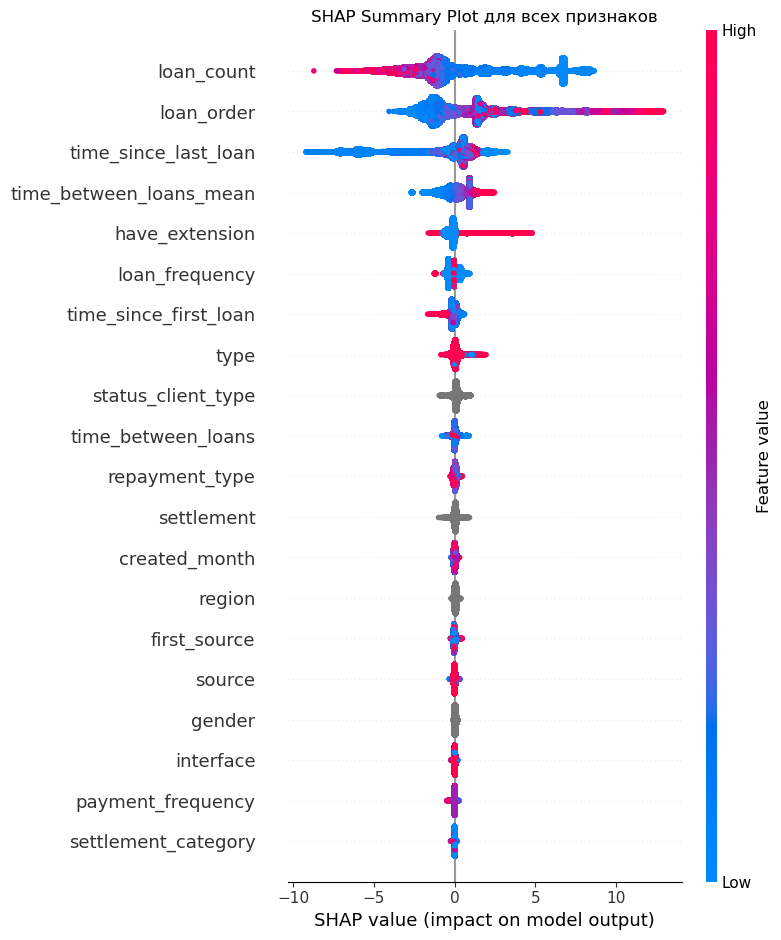

In [ ]:
# Общий SHAP summary plot для всех признаков
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_array, X_val[non_encoded_cat_features], plot_type='dot', show=False)
plt.title("SHAP Summary Plot для всех признаков")
plt.tight_layout()
plt.show()

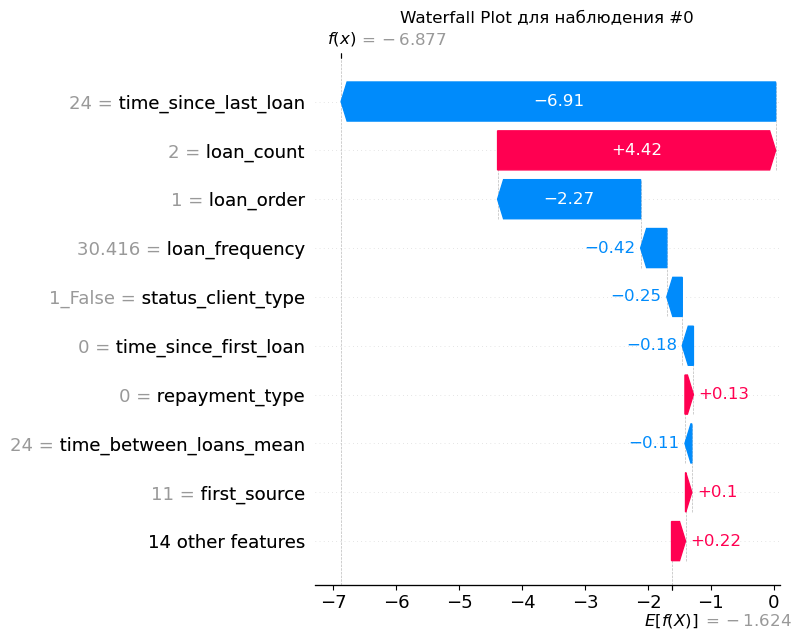

In [ ]:
# Waterfall plot для первого примера
sample_idx = 0
# Создаем объект Explanation для выбранного примера
shap_expl = shap.Explanation(
    values=shap_values_array[sample_idx],
    base_values=shap_values[sample_idx, -1],
    data=X_val[non_encoded_cat_features].iloc[sample_idx],
    feature_names=X_val[non_encoded_cat_features].columns
)
plt.figure(figsize=(12, 6))
shap.waterfall_plot(shap_expl, show=False)
plt.title(f"Waterfall Plot для наблюдения #{sample_idx}")
plt.tight_layout()
plt.show()

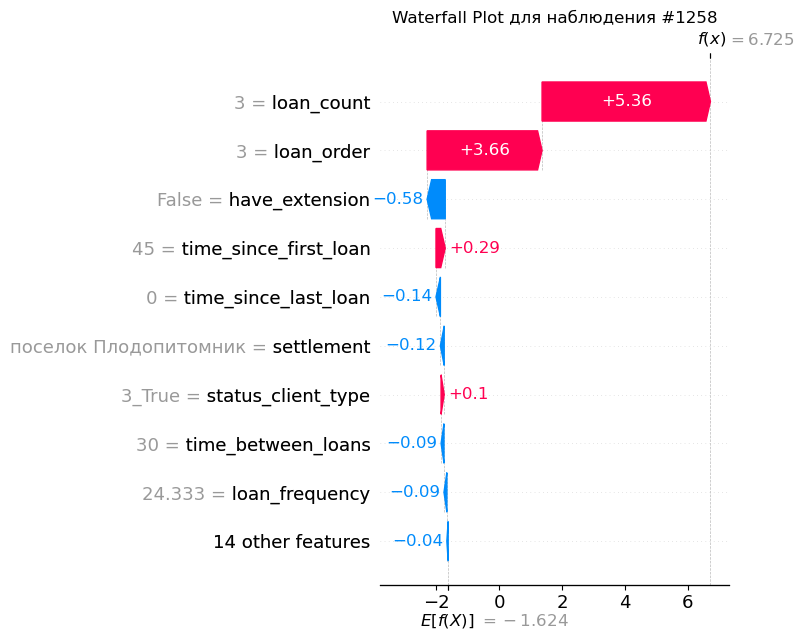

In [ ]:
# Waterfall plot для 1258 примера
sample_idx = 1258
# Создаем объект Explanation для выбранного примера
shap_expl = shap.Explanation(
    values=shap_values_array[sample_idx],
    base_values=shap_values[sample_idx, -1],
    data=X_val[non_encoded_cat_features].iloc[sample_idx],
    feature_names=X_val[non_encoded_cat_features].columns
)
plt.figure(figsize=(12, 6))
shap.waterfall_plot(shap_expl, show=False)
plt.title(f"Waterfall Plot для наблюдения #{sample_idx}")
plt.tight_layout()
plt.show()

#### Сохранение модели

In [ ]:
# Сохранение модели
catboost_model.save_model(PATH_SAVE / 'catboost_model.cbm')

### XGBoost

#### Найдём оптимальные гиперпараметры для модели

In [ ]:
# Функция для расчёта F1-score (бинаризация с порогом 0.5)
def f1_eval(y_true, y_pred):
    y_pred_binary = (y_pred > 0.5).astype(int)
    return -f1_score(y_true, y_pred_binary)

In [ ]:
# Определение функции-цели для оптимизации гиперпараметров
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int("n_estimators", 5000, 10000, step=2500),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'objective': 'binary:logistic',
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'device': DEVICE_L,
        'eval_metric': f1_eval,
        'early_stopping_rounds': 500,
        'scale_pos_weight': scale_pos_weight
    }

    model = XGBClassifier(**params)

    try:
        model.fit(
            X_train[encoded_cat_features],
            y_train,
            eval_set=[(X_val[encoded_cat_features], y_val)],
            verbose=False)
        )
    except Exception as e:
        print(f"Ошибка при обучении: {e}")
        return 0.0  # В случае ошибки возвращаем минимальное значение метрики

    # Предсказание и вычисление F1-score на валидационной выборке
    y_pred = model.predict(X_val[encoded_cat_features])
    f1 = f1_score(y_val, y_pred)

    # Регистрация промежуточных результатов для возможности обрезки
    trial.report(f1, step=trial.number)

    # Если результат ниже порога, прекращаем эксперимент (prune)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return f1

In [ ]:
# Настройка прунера
pruner = optuna.pruners.MedianPruner()

# Указываем хранилище для XGBoost – отдельная база данных
storage_xgb = "sqlite:///study_xgb.db"

# Создание или загрузка исследования с именем "study_xgb"
study_xgb = optuna.create_study(
    study_name="study_xgb",
    direction="maximize",
    pruner=pruner,
    storage=storage_xgb,
    load_if_exists=True  # Если исследование уже существует, загрузить его
)

# Оптимизация целевой функции для XGBoost
study_xgb.optimize(objective_xgb, n_trials=40, timeout=21600)  #40 trials или 6 часов

[I 2025-02-20 12:47:15,462] Using an existing study with name 'study_xgb' instead of creating a new one.
[I 2025-02-20 12:54:09,402] Trial 8 finished with value: 0.8925017110934349 and parameters: {'n_estimators': 7500, 'learning_rate': 0.0018907494398924492, 'max_depth': 4, 'subsample': 0.6875955800947691, 'colsample_bytree': 0.8571530785577146, 'gamma': 1.0618248671875272e-05, 'min_child_weight': 8}. Best is trial 7 with value: 0.9108386111485425.
[I 2025-02-20 13:33:19,082] Trial 9 finished with value: 0.9120989312344097 and parameters: {'n_estimators': 5000, 'learning_rate': 0.05365143439316384, 'max_depth': 4, 'subsample': 0.8945349844525936, 'colsample_bytree': 0.5841154909328201, 'gamma': 0.00016071438424792184, 'min_child_weight': 5}. Best is trial 9 with value: 0.9120989312344097.
[I 2025-02-20 14:04:20,716] Trial 10 finished with value: 0.9118661778350283 and parameters: {'n_estimators': 5000, 'learning_rate': 0.2763787334602823, 'max_depth': 3, 'subsample': 0.848464942701567

In [ ]:
best_params_xgb = study_xgb.best_params
# Вывод лучшего результата и параметров
print("Лучший F1-score на валидационной выборке:", study_xgb.best_value)
print("Лучшие гиперпараметры:")
for key, value in best_params_xgb.items():
    print(f"  {key}: {value}")

Лучший F1-score на валидационной выборке: 0.9122976879914256
Лучшие гиперпараметры:
  n_estimators: 7500
  learning_rate: 0.031490292976967434
  max_depth: 10
  subsample: 0.8927135095367856
  colsample_bytree: 0.7201014772842584
  gamma: 0.0004409162996412444
  min_child_weight: 4


#### Обучение модели с лучшими гиперпараметрами

In [ ]:
# Обучение финальной модели с лучшими параметрами
xgb_model = XGBClassifier(**best_params_xgb,
                          random_seed=RANDOM_STATE,
                          n_jobs=-1,
                          device=DEVICE_L,
                          eval_metric=f1_eval,
                          early_stopping_rounds=1000,
                          scale_pos_weight=scale_pos_weight)

In [ ]:
try:
    xgb_model.fit(
        X_train[encoded_cat_features],
        y_train,
        eval_set=[(X_val[encoded_cat_features], y_val)],
        verbose=1000
    )
except Exception as e:
    print(f"Ошибка при обучении: {e}")

[0]	validation_0-logloss:0.60916	validation_0-f1_eval:-0.00000
[1000]	validation_0-logloss:0.14680	validation_0-f1_eval:-0.90818
[2000]	validation_0-logloss:0.14660	validation_0-f1_eval:-0.90880
[3000]	validation_0-logloss:0.14690	validation_0-f1_eval:-0.90908
[4000]	validation_0-logloss:0.14738	validation_0-f1_eval:-0.90928
[5000]	validation_0-logloss:0.14804	validation_0-f1_eval:-0.90941
[6000]	validation_0-logloss:0.14884	validation_0-f1_eval:-0.90946
[6316]	validation_0-logloss:0.14910	validation_0-f1_eval:-0.90951


In [ ]:
# Прогноз и оценка модели
xgb_val_pred =xgb_model.predict(X_val[encoded_cat_features])
f1_val_xgb = f1_score(y_val, xgb_val_pred)
print(f"F1-score на валидационной выборке: {f1_val_xgb:.5f}")

F1-score на валидационной выборке: 0.90955


#### Предсказание на тестовой выборке

In [ ]:
start_time = time.time()  # Запускаем таймер
xgb_test_pred = xgb_model.predict(X_test[encoded_cat_features])
prediction_time_xgb = time.time() - start_time  # Вычисляем затраченное время

print(f"Время предсказания модели: {prediction_time_xgb:.1f} секунд")

Время предсказания модели: 2.7 секунд


#### Сформируем и сохраним файл `submission` для  XGBoost

In [ ]:
submission_xgb = pd.DataFrame({
    "loan_id": X_test["loan_id"],
    "churn": xgb_test_pred
})
submission_xgb.to_csv(PATH_SAVE / 'submission_xgb.csv', index=False)

#### Оценка важности признаков

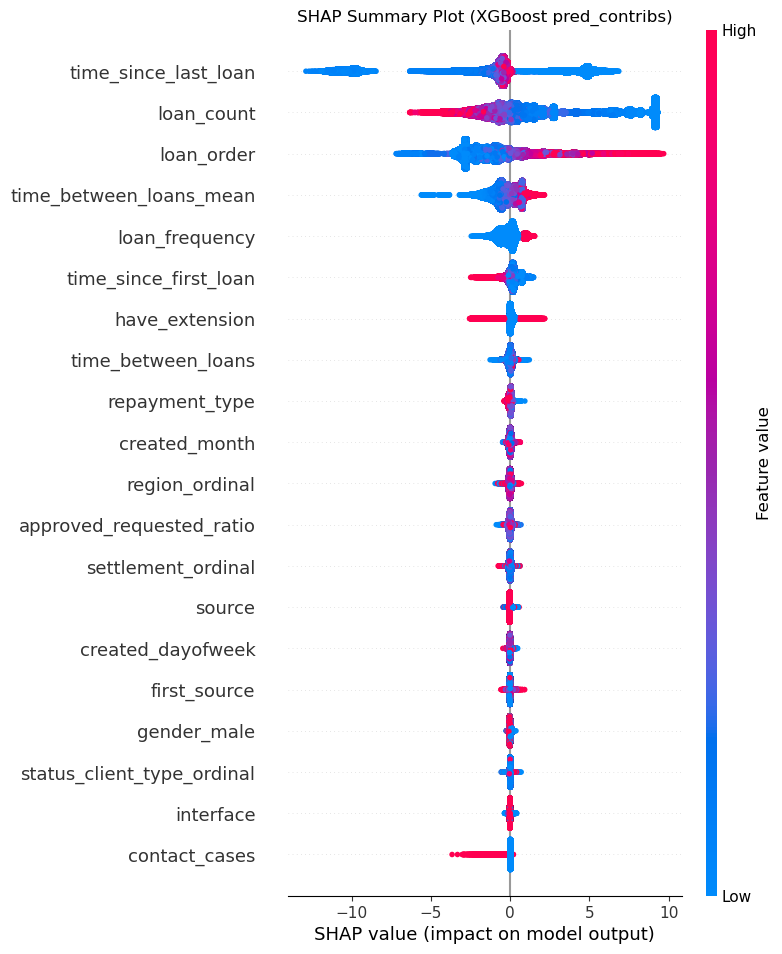

In [ ]:
# Получим низкоуровневый booster через метод get_booster():
booster = xgb_model.get_booster()

# Установим устройство для вычислений:
booster.set_param({"device": DEVICE_L})

# Получаем значения вклада (включая базовую линию) для каждого примера
dval = DMatrix(X_val[encoded_cat_features])
# Метод predict с параметром pred_contribs=True возвращает массив (n_samples, n_features + 1),
# где последний столбец — ожидаемое значение (bias)
shap_contribs = xgb_model.get_booster().predict(dval, pred_contribs=True)
shap_values_xgb = shap_contribs[:, :-1]

shap_values_array_xgb = shap_values_xgb[:, :-1]

# Построим summary plot с использованием полученных значений
shap.summary_plot(shap_values_xgb, X_val[encoded_cat_features], show=False)
plt.title("SHAP Summary Plot (XGBoost pred_contribs)")
plt.show()

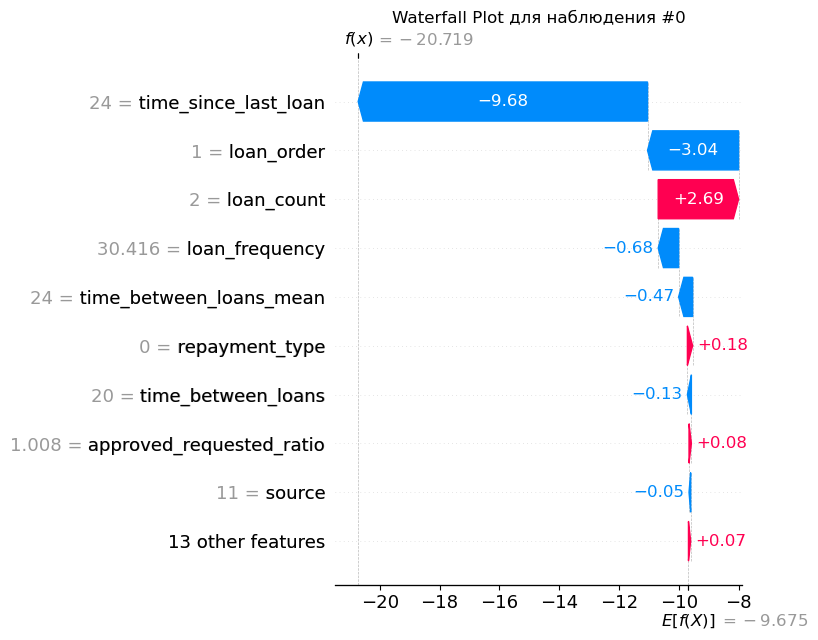

In [ ]:
# Waterfall plot для первого примера
sample_idx = 0
# Создаем объект Explanation для выбранного примера
shap_expl = shap.Explanation(
    values=shap_values_array_xgb[sample_idx],
    base_values=shap_values_array_xgb[sample_idx, -1],
    data=X_val[encoded_cat_features].iloc[sample_idx],
    feature_names=X_val[encoded_cat_features].columns
)
plt.figure(figsize=(12, 6))
shap.waterfall_plot(shap_expl, show=False)
plt.title(f"Waterfall Plot для наблюдения #{sample_idx}")
plt.tight_layout()
plt.show()

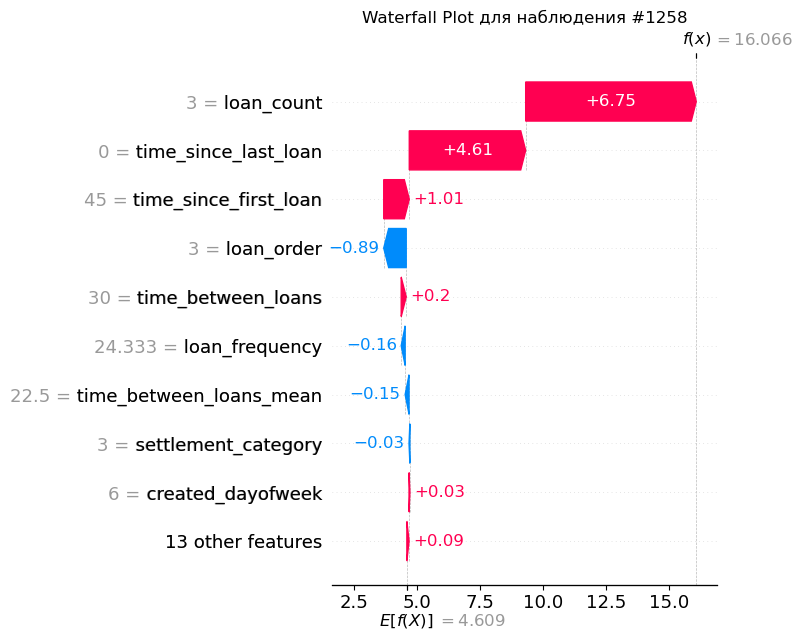

In [ ]:
# Waterfall plot для 1258 примера
sample_idx = 1258
# Создаем объект Explanation для выбранного примера
shap_expl = shap.Explanation(
    values=shap_values_array_xgb[sample_idx],
    base_values=shap_values_array_xgb[sample_idx, -1],
    data=X_val[encoded_cat_features].iloc[sample_idx],
    feature_names=X_val[encoded_cat_features].columns
)
plt.figure(figsize=(12, 6))
shap.waterfall_plot(shap_expl, show=False)
plt.title(f"Waterfall Plot для наблюдения #{sample_idx}")
plt.tight_layout()
plt.show()

#### Сохранение модели

In [ ]:
# Сохранение модели (например, в формате ubj)
xgb_model.save_model(PATH_SAVE / 'xgb_model.ubj')

### LightGBM

#### Найдём оптимальные гиперпараметры для модели

In [ ]:
def objective_lgbm(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 2500, 7500, step=2500),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.05),
        "max_depth": trial.suggest_int("max_depth", 4, 10),
        "random_state": RANDOM_STATE,
        "n_jobs": -1,
        "device": DEVICE,
        "class_weight": class_weights_dict
    }

    model = LGBMClassifier(**params)
    try:
        model.fit(
            X_train[encoded_cat_features], y_train,
            eval_set=[(X_val[encoded_cat_features], y_val)],
            callbacks=[
                early_stopping(stopping_rounds=50),
                log_evaluation(0)
            ]
        )
    except Exception as e:
        print(f"Ошибка при обучении: {e}")
        raise optuna.exceptions.TrialPruned()

    preds = model.predict(X_val[encoded_cat_features])
    f1 = f1_score(y_val, preds)
    trial.report(f1, step=trial.number)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    return f1

In [ ]:
# Настройка прунера
pruner = optuna.pruners.MedianPruner()

# Определяем хранилище для результатов оптимизации (например, SQLite база данных)
storage_lgbm = "sqlite:///study_lgbm.db"

# Создаем или загружаем исследование с именем "study_lgbm"
study_lgbm = optuna.create_study(
    study_name="study_lgbm",
    direction="maximize",
    pruner=pruner,
    storage=storage_lgbm,
    load_if_exists=True  # Если исследование уже существует, загрузить его
)

study_lgbm.optimize(objective_lgbm, n_trials=50, timeout=21600) #50 trials или 6 часов

[I 2025-02-21 00:58:23,953] Using an existing study with name 'study_lgbm' instead of creating a new one.


[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.117908 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[2498]	valid_0's binary_logloss: 0.134674


[I 2025-02-21 01:03:14,017] Trial 8 finished with value: 0.9120273085560195 and parameters: {'n_estimators': 2500, 'learning_rate': 0.02509534624988013, 'max_depth': 10}. Best is trial 4 with value: 0.9123575356569186.


[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.116335 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds


[I 2025-02-21 01:03:50,792] Trial 9 pruned. 


Ошибка при обучении: Check failed: (best_split_info.left_count) > (0) at D:\a\1\s\lightgbm-python\src\treelearner\serial_tree_learner.cpp, line 846 .

[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.117546 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds


[I 2025-02-21 01:04:24,246] Trial 10 pruned. 


Ошибка при обучении: Check failed: (best_split_info.left_count) > (0) at D:\a\1\s\lightgbm-python\src\treelearner\serial_tree_learner.cpp, line 846 .

[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.110374 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2773]	valid_0'

[I 2025-02-21 01:09:56,162] Trial 11 finished with value: 0.911999422725233 and parameters: {'n_estimators': 5000, 'learning_rate': 0.02376222344029141, 'max_depth': 8}. Best is trial 4 with value: 0.9123575356569186.


[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.114313 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds


[I 2025-02-21 01:16:42,768] Trial 12 pruned. 


Ошибка при обучении: Check failed: (best_split_info.left_count) > (0) at D:\a\1\s\lightgbm-python\src\treelearner\serial_tree_learner.cpp, line 846 .

[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.114929 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1429]	valid_0'

[I 2025-02-21 01:19:41,711] Trial 13 finished with value: 0.9119851707528278 and parameters: {'n_estimators': 5000, 'learning_rate': 0.03936135633796595, 'max_depth': 8}. Best is trial 4 with value: 0.9123575356569186.


[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.116743 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds


[I 2025-02-21 01:20:16,271] Trial 14 pruned. 


Ошибка при обучении: Check failed: (best_split_info.left_count) > (0) at D:\a\1\s\lightgbm-python\src\treelearner\serial_tree_learner.cpp, line 846 .

[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.115787 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[7

[I 2025-02-21 01:34:34,373] Trial 15 finished with value: 0.912170405063805 and parameters: {'n_estimators': 7500, 'learning_rate': 0.010384436513389632, 'max_depth': 9}. Best is trial 4 with value: 0.9123575356569186.


[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.112872 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1440]	valid_0's binary_logloss: 0.13485


[I 2025-02-21 01:37:34,417] Trial 16 finished with value: 0.9119427627958173 and parameters: {'n_estimators': 5000, 'learning_rate': 0.03448701861879672, 'max_depth': 10}. Best is trial 4 with value: 0.9123575356569186.


[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.116380 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3075]	valid_0's binary_logloss: 0.135272


[I 2025-02-21 01:44:10,413] Trial 17 finished with value: 0.9116081081386085 and parameters: {'n_estimators': 7500, 'learning_rate': 0.012294906246085474, 'max_depth': 10}. Best is trial 4 with value: 0.9123575356569186.


[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.114938 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1595]	valid_0's binary_logloss: 0.134845


[I 2025-02-21 01:47:31,719] Trial 18 finished with value: 0.9118422804179442 and parameters: {'n_estimators': 2500, 'learning_rate': 0.03204403927482227, 'max_depth': 9}. Best is trial 4 with value: 0.9123575356569186.


[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.112331 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1048]	valid_0's binary_logloss: 0.134837


[I 2025-02-21 01:49:45,869] Trial 19 finished with value: 0.9118916199932782 and parameters: {'n_estimators': 5000, 'learning_rate': 0.04771972573731164, 'max_depth': 9}. Best is trial 4 with value: 0.9123575356569186.


[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.116565 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[2499]	valid_0's binary_logloss: 0.135393


[I 2025-02-21 01:55:15,615] Trial 20 finished with value: 0.9115216630740235 and parameters: {'n_estimators': 2500, 'learning_rate': 0.01364696294905629, 'max_depth': 10}. Best is trial 4 with value: 0.9123575356569186.


[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.115675 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2025-02-21 01:55:53,575] Trial 21 pruned. 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Ошибка при обучении: Check failed: (best_split_info.left_count) > (0) at D:\a\1\s\lightgbm-python\src\treelearner\serial_tree_learner.cpp, line 846 .

[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.116213 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don

[I 2025-02-21 01:56:21,417] Trial 22 pruned. 


Ошибка при обучении: Check failed: (best_split_info.left_count) > (0) at D:\a\1\s\lightgbm-python\src\treelearner\serial_tree_learner.cpp, line 846 .

[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.116984 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3524]	valid_0'

[I 2025-02-21 02:02:49,730] Trial 23 finished with value: 0.9123265747743077 and parameters: {'n_estimators': 5000, 'learning_rate': 0.028611159399797918, 'max_depth': 9}. Best is trial 4 with value: 0.9123575356569186.


[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.116048 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1284]	valid_0's binary_logloss: 0.134812


[I 2025-02-21 02:05:27,773] Trial 24 finished with value: 0.9119152524792438 and parameters: {'n_estimators': 2500, 'learning_rate': 0.04255060671993753, 'max_depth': 10}. Best is trial 4 with value: 0.9123575356569186.


[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.121001 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3390]	valid_0's binary_logloss: 0.134571


[I 2025-02-21 02:12:01,298] Trial 25 finished with value: 0.912177151720655 and parameters: {'n_estimators': 7500, 'learning_rate': 0.021640205025147644, 'max_depth': 8}. Best is trial 4 with value: 0.9123575356569186.


[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.115804 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3985]	valid_0's binary_logloss: 0.134364


[I 2025-02-21 02:19:07,736] Trial 26 finished with value: 0.9122658367905246 and parameters: {'n_estimators': 5000, 'learning_rate': 0.029770016609128012, 'max_depth': 9}. Best is trial 4 with value: 0.9123575356569186.


[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.112894 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1914]	valid_0's binary_logloss: 0.134846


[I 2025-02-21 02:23:02,420] Trial 27 finished with value: 0.9118264236429193 and parameters: {'n_estimators': 5000, 'learning_rate': 0.027346854981317024, 'max_depth': 9}. Best is trial 4 with value: 0.9123575356569186.


[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.115582 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds


[I 2025-02-21 02:23:25,003] Trial 28 pruned. 


Ошибка при обучении: Check failed: (best_split_info.left_count) > (0) at D:\a\1\s\lightgbm-python\src\treelearner\serial_tree_learner.cpp, line 846 .

[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.110247 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4839]	valid_0'

[I 2025-02-21 02:32:09,970] Trial 29 finished with value: 0.9121728996715753 and parameters: {'n_estimators': 5000, 'learning_rate': 0.02129760441115051, 'max_depth': 9}. Best is trial 4 with value: 0.9123575356569186.


[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.126209 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[2500]	valid_0's binary_logloss: 0.135304


[I 2025-02-21 02:37:31,980] Trial 30 finished with value: 0.9115587302662017 and parameters: {'n_estimators': 2500, 'learning_rate': 0.01564958960282355, 'max_depth': 8}. Best is trial 4 with value: 0.9123575356569186.


[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.113350 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1988]	valid_0's binary_logloss: 0.134749


[I 2025-02-21 02:41:32,044] Trial 31 finished with value: 0.9119697581418219 and parameters: {'n_estimators': 5000, 'learning_rate': 0.02919926861206934, 'max_depth': 10}. Best is trial 4 with value: 0.9123575356569186.


[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.114291 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds


[I 2025-02-21 02:49:59,345] Trial 32 pruned. 


Ошибка при обучении: Check failed: (best_split_info.left_count) > (0) at D:\a\1\s\lightgbm-python\src\treelearner\serial_tree_learner.cpp, line 846 .

[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.115417 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds


[I 2025-02-21 02:50:31,432] Trial 33 pruned. 


Ошибка при обучении: Check failed: (best_split_info.left_count) > (0) at D:\a\1\s\lightgbm-python\src\treelearner\serial_tree_learner.cpp, line 846 .

[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.116734 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3190]	valid_0'

[I 2025-02-21 02:56:58,973] Trial 34 finished with value: 0.911941429615395 and parameters: {'n_estimators': 5000, 'learning_rate': 0.01916497569516783, 'max_depth': 8}. Best is trial 4 with value: 0.9123575356569186.


[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.113596 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1494]	valid_0's binary_logloss: 0.134916


[I 2025-02-21 03:00:05,054] Trial 35 finished with value: 0.9118476568669479 and parameters: {'n_estimators': 2500, 'learning_rate': 0.03379764677695062, 'max_depth': 9}. Best is trial 4 with value: 0.9123575356569186.


[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.116296 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[808]	valid_0's binary_logloss: 0.136337


[I 2025-02-21 03:02:07,527] Trial 36 finished with value: 0.910939647067332 and parameters: {'n_estimators': 5000, 'learning_rate': 0.02739969194488571, 'max_depth': 9}. Best is trial 4 with value: 0.9123575356569186.


[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.110802 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[945]	valid_0's binary_logloss: 0.135765


[I 2025-02-21 03:04:25,113] Trial 37 finished with value: 0.9113500403108338 and parameters: {'n_estimators': 5000, 'learning_rate': 0.028835446665149495, 'max_depth': 10}. Best is trial 4 with value: 0.9123575356569186.


[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.115623 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3980]	valid_0's binary_logloss: 0.134452


[I 2025-02-21 03:12:02,760] Trial 38 finished with value: 0.9121840614139083 and parameters: {'n_estimators': 5000, 'learning_rate': 0.023315656404134848, 'max_depth': 7}. Best is trial 4 with value: 0.9123575356569186.


[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.114321 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3076]	valid_0's binary_logloss: 0.134381


[I 2025-02-21 03:17:36,292] Trial 39 finished with value: 0.9122564212377013 and parameters: {'n_estimators': 5000, 'learning_rate': 0.036583668757795125, 'max_depth': 9}. Best is trial 4 with value: 0.9123575356569186.


[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.114630 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1114]	valid_0's binary_logloss: 0.135391


[I 2025-02-21 03:20:09,604] Trial 40 finished with value: 0.9115634282206152 and parameters: {'n_estimators': 2500, 'learning_rate': 0.030977182175252967, 'max_depth': 10}. Best is trial 4 with value: 0.9123575356569186.


[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.111578 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3935]	valid_0's binary_logloss: 0.134431


[I 2025-02-21 03:27:31,189] Trial 41 finished with value: 0.9123109898060145 and parameters: {'n_estimators': 5000, 'learning_rate': 0.024896985123063774, 'max_depth': 8}. Best is trial 4 with value: 0.9123575356569186.


[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.117535 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1937]	valid_0's binary_logloss: 0.135021


[I 2025-02-21 03:31:34,298] Trial 42 finished with value: 0.9117576720197458 and parameters: {'n_estimators': 5000, 'learning_rate': 0.025420995803621907, 'max_depth': 8}. Best is trial 4 with value: 0.9123575356569186.


[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.116838 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2729]	valid_0's binary_logloss: 0.1352


[I 2025-02-21 03:37:23,193] Trial 43 finished with value: 0.911559497179592 and parameters: {'n_estimators': 7500, 'learning_rate': 0.015959671391698398, 'max_depth': 8}. Best is trial 4 with value: 0.9123575356569186.


[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.113980 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[2500]	valid_0's binary_logloss: 0.135031


[I 2025-02-21 03:42:38,201] Trial 44 finished with value: 0.9116617023197039 and parameters: {'n_estimators': 2500, 'learning_rate': 0.018333860549776277, 'max_depth': 8}. Best is trial 4 with value: 0.9123575356569186.


[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.116153 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3417]	valid_0's binary_logloss: 0.134531


[I 2025-02-21 03:49:23,019] Trial 45 finished with value: 0.9122360928898927 and parameters: {'n_estimators': 5000, 'learning_rate': 0.023658675124183553, 'max_depth': 7}. Best is trial 4 with value: 0.9123575356569186.


[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.114895 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2066]	valid_0's binary_logloss: 0.134839


[I 2025-02-21 03:53:35,203] Trial 46 finished with value: 0.9118023969388492 and parameters: {'n_estimators': 5000, 'learning_rate': 0.026434873721267564, 'max_depth': 9}. Best is trial 4 with value: 0.9123575356569186.


[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.113278 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3214]	valid_0's binary_logloss: 0.134364


[I 2025-02-21 03:59:24,993] Trial 47 finished with value: 0.9123162033959415 and parameters: {'n_estimators': 5000, 'learning_rate': 0.033404179542140505, 'max_depth': 9}. Best is trial 4 with value: 0.9123575356569186.


[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.114725 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2323]	valid_0's binary_logloss: 0.134491


[I 2025-02-21 04:03:46,544] Trial 48 finished with value: 0.9122367338659695 and parameters: {'n_estimators': 5000, 'learning_rate': 0.04099967222845044, 'max_depth': 8}. Best is trial 4 with value: 0.9123575356569186.


[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.116893 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[4999]	valid_0's binary_logloss: 0.134741


[I 2025-02-21 04:13:42,596] Trial 49 finished with value: 0.9119964272583945 and parameters: {'n_estimators': 5000, 'learning_rate': 0.010961112410172332, 'max_depth': 10}. Best is trial 4 with value: 0.9123575356569186.


[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.115848 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[654]	valid_0's binary_logloss: 0.136301


[I 2025-02-21 04:15:22,995] Trial 50 finished with value: 0.9108844213837615 and parameters: {'n_estimators': 5000, 'learning_rate': 0.03479453870096683, 'max_depth': 9}. Best is trial 4 with value: 0.9123575356569186.


[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.118152 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds


[I 2025-02-21 04:18:41,878] Trial 51 pruned. 


Ошибка при обучении: Check failed: (best_split_info.left_count) > (0) at D:\a\1\s\lightgbm-python\src\treelearner\serial_tree_learner.cpp, line 846 .

[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.119550 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[2

[I 2025-02-21 04:23:43,857] Trial 52 finished with value: 0.9118948693310236 and parameters: {'n_estimators': 2500, 'learning_rate': 0.020071833634971073, 'max_depth': 10}. Best is trial 4 with value: 0.9123575356569186.


[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.117153 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds


[I 2025-02-21 04:24:48,684] Trial 53 pruned. 


Ошибка при обучении: Check failed: (best_split_info.left_count) > (0) at D:\a\1\s\lightgbm-python\src\treelearner\serial_tree_learner.cpp, line 846 .

[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.117781 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1002]	valid_0'

[I 2025-02-21 04:26:59,714] Trial 54 finished with value: 0.9118152056441878 and parameters: {'n_estimators': 5000, 'learning_rate': 0.04483205883503521, 'max_depth': 9}. Best is trial 4 with value: 0.9123575356569186.


[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.114591 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds


[I 2025-02-21 04:27:50,322] Trial 55 pruned. 


Ошибка при обучении: Check failed: (best_split_info.left_count) > (0) at D:\a\1\s\lightgbm-python\src\treelearner\serial_tree_learner.cpp, line 846 .

[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.116951 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1702]	valid_0'

[I 2025-02-21 04:31:22,234] Trial 56 finished with value: 0.9117344405831115 and parameters: {'n_estimators': 5000, 'learning_rate': 0.028565055279872676, 'max_depth': 9}. Best is trial 4 with value: 0.9123575356569186.


[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.118930 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.293779 -> initscore=-0.877099
[LightGBM] [Info] Start training from score -0.877099
Training until validation scores don't improve for 50 rounds


[I 2025-02-21 04:35:43,815] Trial 57 pruned. 


Ошибка при обучении: Check failed: (best_split_info.left_count) > (0) at D:\a\1\s\lightgbm-python\src\treelearner\serial_tree_learner.cpp, line 846 .



In [ ]:
best_params_lgbm = study_lgbm.best_params
# Вывод лучшего результата и параметров
print("Лучший F1-score на валидационной выборке:", study_lgbm.best_value)
print("Лучшие гиперпараметры:")
for key, value in best_params_lgbm.items():
    print(f"  {key}: {value}")

Лучший F1-score на валидационной выборке: 0.9121598160131676
Лучшие гиперпараметры:
  n_estimators: 5000
  learning_rate: 0.016295030305083995
  max_depth: 9


#### Обучение модели с лучшими гиперпараметрами

In [ ]:
# Инициализация модели с лучшими гиперпараметрами
lgbm_model = LGBMClassifier(
    **best_params_lgbm,
    objective='binary',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    device=DEVICE,
    class_weight=class_weights_dict
)

In [ ]:
# Обучение модели
try:
    lgbm_model.fit(
        X_train[encoded_cat_features], y_train,
        eval_set=[(X_val[encoded_cat_features], y_val)],
        callbacks=[
            early_stopping(stopping_rounds=50),  # Ранняя остановка
            log_evaluation(1000)  # Вывод логов каждые 1000 итераций
        ]
    )
except Exception as e:
    print(f"Ошибка при обучении: {e}")

[LightGBM] [Info] Number of positive: 948603, number of negative: 2280362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 3228965, number of used features: 23
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (49.27 MB) transferred to GPU in 0.115783 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 50 rounds
[1000]	valid_0's binary_logloss: 0.155392
[2000]	valid_0's binary_logloss: 0.153112
[3000]	valid_0's binary_logloss: 0.152299
Early stopping, best iteration is:
[3804]	valid_0's binary_logloss: 0.151875


In [ ]:
# Предсказание на валидационной выборке
lgbm_val_pred = lgbm_model.predict(X_val[encoded_cat_features])

In [ ]:
# Расчёт F1-score
f1_val_lgbm = f1_score(y_val, lgbm_val_pred)
print(f"F1-score на валидационной выборке: {f1_val_lgbm:.5f}")

F1-score на валидационной выборке: 0.91218


#### Предсказание на тестовой выборке

In [ ]:
start_time = time.time()  # Запускаем таймер
lgbm_test_pred = lgbm_model.predict(X_test[encoded_cat_features])
prediction_time_lgbm = time.time() - start_time  # Вычисляем затраченное время

print(f"Время предсказания модели: {prediction_time_lgbm:.1f} секунд")

Время предсказания модели: 45.9 секунд


#### Сформируем и сохраним файл `submission` для LGBM

In [ ]:
submission_lgbm = pd.DataFrame({
    "loan_id": X_test["loan_id"],
    "churn": lgbm_test_pred
})
submission_lgbm.to_csv(PATH_SAVE / 'submission_lgbm.csv', index=False)

#### Оценка важности признаков

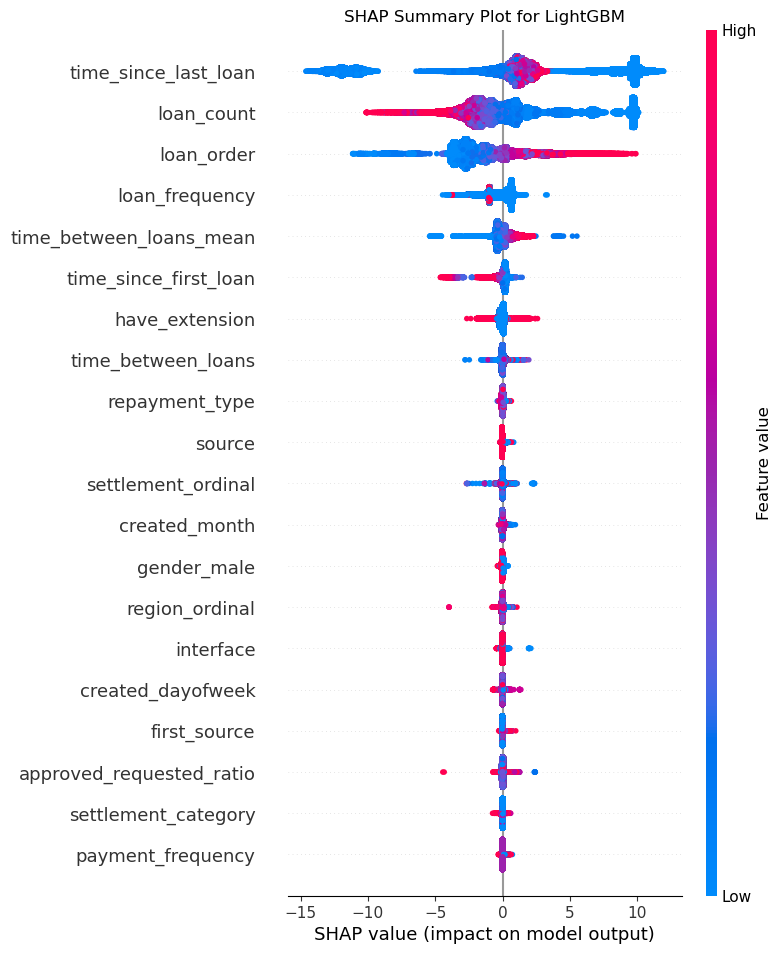

In [ ]:
# Получение SHAP значений
# Метод predict с параметром pred_contrib=True возвращает матрицу [n_samples x (n_features+1)]
# Последний столбец – базовое значение (expected value)
shap_values = lgbm_model.predict(X_val[encoded_cat_features], pred_contrib=True)
shap_vals = shap_values[:, :-1]

# Построение summary plot (график распределения влияния признаков)
shap.summary_plot(shap_vals, X_val[encoded_cat_features], show=False)
plt.title("SHAP Summary Plot for LightGBM")
plt.show()

#### Сохранение модели

In [ ]:
# Сохранение модели с помощью pickle
with open(PATH_SAVE / "lgbm_model.pkl", "wb") as f:
    pickle.dump(lgbm_model, f)

### Заключение


В данном блокноте проведён комплексный анализ и построение модели для прогнозирования оттока клиентов. Основные этапы проекта можно описать следующим образом:

- **Подготовка окружения:**  
  Импортированы необходимые библиотеки и настроено рабочее пространство, что позволило обеспечить стабильную работу всех компонентов проекта.

- **Загрузка и предобработка данных:**  
  Данные загружались с использованием Dask и обрабатывались с помощью класса `DataPreprocessorOptimized`, который выполнял очистку, трансформацию и кодирование информации, обеспечивая корректное представление исходных данных, сгенерированы дополнительные признаки, позволяющие глубже охарактеризовать клиентов и их займы, что способствовало улучшению описательной способности модели.

- **Разведочный анализ:**  
  Проведена детальная визуализация распределения целевой переменной, а также выполнена проверка гипотез с применением t‑теста для выявления статистически значимых различий между группами клиентов.

- **Обучение моделей:**  
  Данные были разделены на обучающую и тестовую выборки, и для прогнозирования оттока клиентов обучены модели CatBoost, XGBoost и LightGBM. Все модели продемонстрировали схожие результаты, однако наилучшие показатели достигла модель CatBoost, показавшая F1‑score 0.9236 на тестовых данных при времени предсказания 11.3 секунды. Для этой модели были подобраны следующие гиперпараметры с помощью Optuna:  
  - **n_estimators:** 2500  
  - **max_depth:** 8  
  - **learning_rate:** 0.13821493790358336
  - **l2_leaf_reg:** 3.926232424209116
  - **border_count:** 152

- **Используемые признаки:**  
  В модель были включены такие ключевые показатели, как:  
  `approved_requested_ratio`, `contact_cases`, `created_dayofweek`, `created_month`, `first_source`, `gender`, `have_extension`, `interface`, `loan_count`, `loan_frequency`, `loan_order`, `payment_frequency`, `region`, `repayment_type`, `settlement`, `settlement_category`, `source`, `status_client_type`, `time_between_loans`, `time_between_loans_mean`, `time_since_first_loan`, `time_since_last_loan`, `type`.

- **Наиболее значимые признаки:**  
  - **loan_count:** Общее количество займов, оформленных клиентом, что позволяет оценить его кредитную активность и историю сотрудничества.  
  - **loan_order:** Порядковый номер займа в истории клиента, позволяющий определить последовательность обращений за кредитными продуктами.  
  - **time_between_loans_mean:** Среднее значение времени между займами по клиенту, позволяющее оценить регулярность обращения за кредитными продуктами.  
  - **time_since_last_loan:** Количество дней между датой текущей заявки и датой последнего займа, показывающее недавнюю активность клиента в сфере кредитования.  
  - **have_extension:** Индикатор наличия пролонгации по займу, свидетельствующий о продлении срока выплаты.

**Портрет клиента склонного к оттоку:**  
Клиент, склонный к оттоку, характеризуется как относительно новый с меньшим количеством займов. Он имеет нерегулярный график заимствований – последний займ оформлен совсем недавно, а интервалы между займами немного увеличены. При этом такой клиент чаще пользуется пролонгациями и выбирает менее выгодные условия погашения, что может отражать его финансовые трудности.

**Перспективы дальнейшего развития проекта:**  
Предложенный подход можно развивать, добавляя новые модели, расширяя этапы предобработки данных и проводя ещё более глубокий анализ признаков. Это позволит не только повысить точность прогнозирования, но и лучше понять ключевые факторы, влияющие на отток клиентов.